# Elastica Initilization

In [1]:
!pip install pyelastica

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 73.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.41.1
    Uninstalling llvmlite-0.41.1:
      Successfully uninstalled llvmlite-0.41.1
  Attempting uninstall: numba
    Found existing installation: numba 0.58.1
    Uninstalling numba-0.58.1:
      Successfully uninstalled numba-0.58.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which i

In [1]:
!pip install "pyelastica[examples, docs]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.9/396.9 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 7.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of sphinx-autodoc-typehints to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of sphinx-autodoc-typehints to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 8.7 MB/s eta 0:00:00
  Attempting uninstall: markdown-it

# Main Code - I Beam

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb
import elastica as ea
from elastica.typing import SystemType, RodType
from numba import njit

In [3]:
import numpy as np


class AnalyticalDynamicCantilever:
    """
    This class computes the analytical solution to a cantilever's dynamic response
    to an initial velocity profile based on the Euler-Bernoulli beam theory.

    Given the generic dynamic beam equation and boundary conditions imposed on a cantilever,
    nontrivial solutions exist only when

        cosh(beta * base_length) * cos(beta * base_length) + 1 = 0

    where beta can be used to determine the natural frequencies of the cantilever beam:

        omega = beta^2 * sqrt(E * I / mu)

    The first four roots to beta are given as

        betas = [0.596864*pi, 1.49418*pi, 2.50025*pi, 3.49999*pi] / base_length

    The class solves for the analytical solution at a single natural frequency by computing
    the non-parametrized mode shapes as well as a mode parameter. The parameter is determined
    by the initial condition of the rod, namely, the end_velocity input. The free vibration
    equation can then be applied to determine beam deflection at a given time at any position
    of the rod:

        w(x, t) = Re[mode_shape * exp(-1j * omega * t)]

    For details, refer to
    https://en.wikipedia.org/wiki/Euler%E2%80%93Bernoulli_beam_theory#Dynamic_beam_equation
    or
    Han et al (1998), Dynamics of Transversely Vibrating Beams
    Using Four Engineering Theories

        Attributes
        ----------
        base_length: float
            Total length of the rod
        base_area: float
            Cross-sectional area of the rod
        moment_of_inertia: float
            Second moment of area of the rod's cross-section
        young's_modulus: float
            Young's modulus of the rod
        density: float
            Density of the rod
        mode: int
            Index of the first 'mode' th natural frequency.
            Up to the first four modes are supported.
        end_velocity: float
            Initial oscillatory velocity at the end of the rod
    """

    def __init__(
        self,
        base_length,
        base_area,
        moment_of_inertia,
        youngs_modulus,
        density,
        mode,
        end_velocity=0.0,
    ):
        self.base_length = base_length
        self.end_velocity = end_velocity

        if not (isinstance(mode, int) and mode >= 0 and mode < 5):
            raise ValueError(
                "Unsupported mode value, please provide a integer value from 0-4"
            )

        self.mode = mode

        betas = np.array([0.596864, 1.49418, 2.50025, 3.49999]) * np.pi / base_length
        self.beta = betas[mode]
        self.omega = (self.beta ** 2) * np.sqrt(
            youngs_modulus
            * moment_of_inertia
            / (density * base_area * base_length ** 4)
        )

        nonparametrized_mode_at_end = self._compute_nonparametrized_mode(
            base_length, base_length, self.beta
        )
        self.mode_param = end_velocity / (
            -1j * self.omega * nonparametrized_mode_at_end
        )

    def get_initial_velocity_profile(self, positions):
        initial_velocities = []

        for x in positions:
            initial_velocities.append(
                np.real(
                    (-1j * self.omega * self.mode_param)
                    * self._compute_nonparametrized_mode(
                        self.base_length * x, self.base_length, self.beta
                    )
                )
            )
        return np.array(initial_velocities)

    def get_time_dependent_positions(self, position, time_array):
        time_dependent_positions = (
            self.mode_param
            * self._compute_nonparametrized_mode(
                self.base_length * position, self.base_length, self.beta
            )
            * np.exp(-1j * self.omega * time_array)
        )
        return np.real(time_dependent_positions)

    def get_time_dependent_velocities(self, position, time_array):
        time_dependent_velocities = (
            (-1j * self.omega * self.mode_param)
            * self._compute_nonparametrized_mode(
                self.base_length * position, self.base_length, self.beta
            )
            * np.exp(-1j * self.omega * time_array)
        )
        return np.real(time_dependent_velocities)

    def get_omega(self):
        return self.omega

    def get_amplitude(self):
        return self.end_velocity / self.omega

    @staticmethod
    def _compute_nonparametrized_mode(x, base_length, beta):
        a = np.cosh(beta * x) - np.cos(beta * x)
        b = np.cos(beta * base_length) + np.cosh(beta * base_length)
        c = np.sin(beta * base_length) + np.sinh(beta * base_length)
        d = np.sin(beta * x) - np.sinh(beta * x)
        return a + b / c * d

In [4]:
class EndpointForcesSin(ea.external_forces.NoForces):
    """
    This class applies constant forces on the endpoint nodes.

        Attributes
        ----------
        start_force: numpy.ndarray
            1D (dim) array containing data with 'float' type. Force applied to first node of the system.
        end_force: numpy.ndarray
            1D (dim) array containing data with 'float' type. Force applied to last node of the system.
        ramp_up_time: float
            Applied forces are ramped up until ramp up time.

    """

    def __init__(self, start_force, end_force, ramp_up_time):
        """

        Parameters
        ----------
        start_force: numpy.ndarray
            1D (dim) array containing data with 'float' type.
            Force applied to first node of the system.
        end_force: numpy.ndarray
            1D (dim) array containing data with 'float' type.
            Force applied to last node of the system.
        ramp_up_time: float
            Applied forces are ramped up until ramp up time.

        """
        super(EndpointForcesSin, self).__init__()
        self.start_force = start_force
        self.end_force = end_force
        assert ramp_up_time > 0.0
        self.ramp_up_time = ramp_up_time


    def apply_forces(self, system: SystemType, time=0.0):
        self.compute_end_point_forces(
            system.external_forces,
            self.start_force,
            self.end_force,
            time,
            self.ramp_up_time,
        )

    @staticmethod
    @njit(cache=True)
    def compute_end_point_forces(
        external_forces, start_force, end_force, time, ramp_up_time
    ):
        """
        Compute end point forces that are applied on the rod using numba njit decorator.

        Parameters
        ----------
        external_forces: numpy.ndarray
            2D (dim, blocksize) array containing data with 'float' type. External force vector.
        start_force: numpy.ndarray
            1D (dim) array containing data with 'float' type.
        end_force: numpy.ndarray
            1D (dim) array containing data with 'float' type.
            Force applied to last node of the system.
        time: float
        ramp_up_time: float
            Applied forces are ramped up until ramp up time.

        Returns
        -------

        """
        w = 0.5 #omega present in sinusoidal function

        factor = min(1.0, time / ramp_up_time)
        external_forces[..., 0] += start_force * factor * np.sin(w*time)
        external_forces[..., -1] += end_force * factor * np.sin(w*time)

In [5]:
def analytical_shearable(arg_rod, arg_end_force, n_elem=500):
    base_length = np.sum(arg_rod.rest_lengths)
    arg_s = np.linspace(0.0, base_length, n_elem)
    if type(arg_end_force) is np.ndarray:
        acting_force = arg_end_force[np.nonzero(arg_end_force)]
    else:
        acting_force = arg_end_force
    acting_force = np.abs(acting_force)

    linear_prefactor = -acting_force / arg_rod.shear_matrix[0, 0, 0]
    quadratic_prefactor = (
        -acting_force
        * np.sum(arg_rod.rest_lengths)
        / 2.0
        / arg_rod.bend_matrix[0, 0, 0]
    )
    cubic_prefactor = acting_force / 6.0 / arg_rod.bend_matrix[0, 0, 0]
    return (
        arg_s,
        arg_s
        * (linear_prefactor + arg_s * (quadratic_prefactor + arg_s * cubic_prefactor)),
    )


def analytical_unshearable(arg_rod, arg_end_force, n_elem=500):
    base_length = np.sum(arg_rod.rest_lengths)
    arg_s = np.linspace(0.0, base_length, n_elem)
    if type(arg_end_force) is np.ndarray:
        acting_force = arg_end_force[np.nonzero(arg_end_force)]
    else:
        acting_force = arg_end_force
    acting_force = np.abs(acting_force)

    quadratic_prefactor = (
        -acting_force
        * np.sum(arg_rod.rest_lengths)
        / 2.0
        / arg_rod.bend_matrix[0, 0, 0]
    )
    cubic_prefactor = acting_force / 6.0 / arg_rod.bend_matrix[0, 0, 0]
    return arg_s, arg_s ** 2 * (quadratic_prefactor + arg_s * cubic_prefactor)


def plot_timoshenko(rod, end_force, SAVE_FIGURE, ADD_UNSHEARABLE_ROD=False):
    fig = plt.figure(figsize=(10, 8), frameon=True, dpi=150)
    ax = fig.add_subplot(111)
    ax.grid(which="minor", color="k", linestyle="--")
    ax.grid(which="major", color="k", linestyle="-")
    analytical_shearable_positon = analytical_shearable(rod, end_force)
    ax.plot(
        analytical_shearable_positon[0],
        analytical_shearable_positon[1],
        "k--",
        label="Timoshenko",
    )
    ax.plot(
        rod.position_collection[2, ...],
        rod.position_collection[0, ...],
        c=to_rgb("xkcd:bluish"),
        label="n=" + str(rod.n_elems),
    )
    if ADD_UNSHEARABLE_ROD:
        analytical_unshearable_positon = analytical_unshearable(rod, end_force)
        ax.plot(
            analytical_unshearable_positon[0],
            analytical_unshearable_positon[1],
            "r-.",
            label="Euler-Bernoulli",
        )
    fig.legend(prop={"size": 20})
    plt.show()
    if SAVE_FIGURE:
        fig.savefig("Timoshenko_beam_test" + str(rod.n_elems) + ".png")


import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb
from scipy.spatial.transform import Rotation

def plot_position(
    plot_params_rod1: dict,
    filename="spherical_joint_test.png",
    SAVE_FIGURE=False,
):

    position_of_rod1 = np.array(plot_params_rod1["position"])

    fig = plt.figure(figsize=(10, 10), frameon=True, dpi=150)
    ax = fig.add_subplot(111)

    ax.grid(which="minor", color="k", linestyle="--")
    ax.grid(which="major", color="k", linestyle="-")
    ax.plot(position_of_rod1[:, 0, -1], position_of_rod1[:, 1, -1], "r-", label="rod1")
    ax.plot(
        position_of_rod1[:, 0, -1],
        c=to_rgb("xkcd:bluish"),
        label="rod2",
    )

    fig.legend(prop={"size": 20})

    plt.show()

    if SAVE_FIGURE:
        fig.savefig(filename)


def plot_orientation(title, time, directors):
    quat = []
    for t in range(len(time)):
        quat_t = Rotation.from_matrix(directors[t].T).as_quat()
        quat.append(quat_t)
    quat = np.array(quat)

    plt.figure(num=title)
    plt.plot(time, quat[:, 0], label="x")
    plt.plot(time, quat[:, 1], label="y")
    plt.plot(time, quat[:, 2], label="z")
    plt.plot(time, quat[:, 3], label="w")
    plt.title(title)
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Quaternion")
    plt.show()


def plot_video(
    plot_params_rod1: dict,
    video_name="video.mp4",
    margin=0.2,
    fps=15,
):  # (time step, x/y/z, node)
    import matplotlib.animation as manimation

    time = plot_params_rod1["time"]
    position_of_rod1 = np.array(plot_params_rod1["position"])

    print("plot video")
    FFMpegWriter = manimation.writers["ffmpeg"]
    metadata = dict(title="Movie Test", artist="Matplotlib", comment="Movie support!")
    writer = FFMpegWriter(fps=fps, metadata=metadata)
    fig = plt.figure(figsize=(10, 8), frameon=True, dpi=150)
    with writer.saving(fig, video_name, 100):
        for time in range(1, len(time)):
            fig.clf()
            ax = plt.axes(projection="3d")  # fig.add_subplot(111)
            ax.grid(which="minor", color="k", linestyle="--")
            ax.grid(which="major", color="k", linestyle="-")
            ax.plot(
                position_of_rod1[time, 0],
                position_of_rod1[time, 1],
                position_of_rod1[time, 2],
                "or",
                label="rod1",
            )

            ax.set_xlim(-5, 5)
            ax.set_ylim(-5, 5)
            ax.set_zlim(0, 6)
            writer.grab_frame()


def plot_video_xy(
    plot_params_rod1: dict,
    video_name="video.mp4",
    margin=0.2,
    fps=15,
):  # (time step, x/y/z, node)
    import matplotlib.animation as manimation

    time = plot_params_rod1["time"]
    position_of_rod1 = np.array(plot_params_rod1["position"])

    print("plot video xy")
    FFMpegWriter = manimation.writers["ffmpeg"]
    metadata = dict(title="Movie Test", artist="Matplotlib", comment="Movie support!")
    writer = FFMpegWriter(fps=fps, metadata=metadata)
    fig = plt.figure()
    plt.axis("equal")
    with writer.saving(fig, video_name, 100):
        for time in range(1, len(time)):
            fig.clf()
            plt.plot(
                position_of_rod1[time, 0], position_of_rod1[time, 1], "or", label="rod1"
            )
            plt.xlim([-5, 5])
            plt.ylim([-5, 5])
            writer.grab_frame()


def plot_video_xz(
    plot_params_rod1: dict,
    video_name="video.mp4",
    margin=0.2,
    fps=15,
):  # (time step, x/y/z, node)
    import matplotlib.animation as manimation

    time = plot_params_rod1["time"]
    position_of_rod1 = np.array(plot_params_rod1["position"])

    print("plot video xz")
    FFMpegWriter = manimation.writers["ffmpeg"]
    metadata = dict(title="Movie Test", artist="Matplotlib", comment="Movie support!")
    writer = FFMpegWriter(fps=fps, metadata=metadata)
    fig = plt.figure()
    plt.axis("equal")
    with writer.saving(fig, video_name, 100):
        for time in range(1, len(time)):
            fig.clf()
            plt.plot(
                position_of_rod1[time, 0], position_of_rod1[time, 2], "or", label="rod1"
            )

            plt.xlim([-5, 5])
            plt.ylim([-5, 5])
            writer.grab_frame()

Bend1: [[[4049.70928002 4049.70928002 4049.70928002 4049.70928002 4049.70928002
   4049.70928002 4049.70928002 4049.70928002 4049.70928002 4049.70928002
   4049.70928002 4049.70928002 4049.70928002 4049.70928002 4049.70928002
   4049.70928002 4049.70928002 4049.70928002 4049.70928002 4049.70928002
   4049.70928002 4049.70928002 4049.70928002 4049.70928002 4049.70928002
   4049.70928002 4049.70928002 4049.70928002 4049.70928002 4049.70928002
   4049.70928002 4049.70928002 4049.70928002 4049.70928002 4049.70928002
   4049.70928002 4049.70928002 4049.70928002 4049.70928002 4049.70928002
   4049.70928002 4049.70928002 4049.70928002 4049.70928002 4049.70928002
   4049.70928002 4049.70928002 4049.70928002 4049.70928002]
  [   0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.            0.            0.            0.            0.
      0.        

100%|██████████| 1190476/1190476 [02:32<00:00, 7788.04it/s]


Final time of simulation is :  499.9999999754841


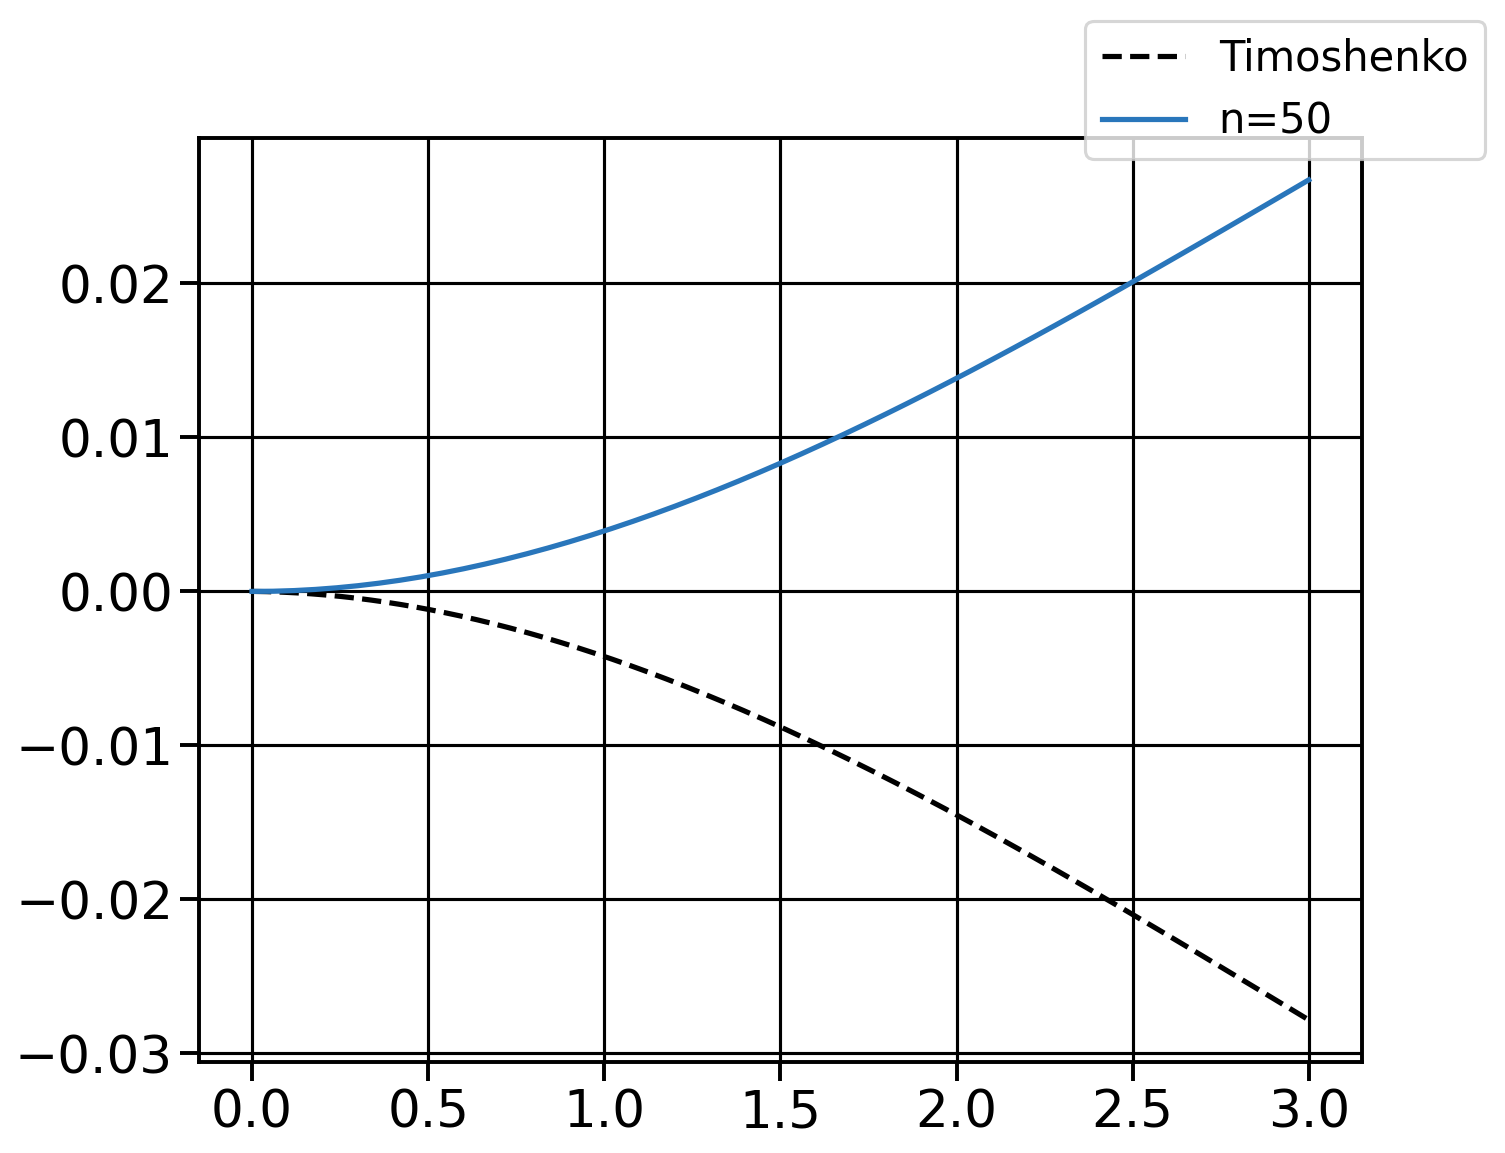

plot video
plot video xy
plot video xz


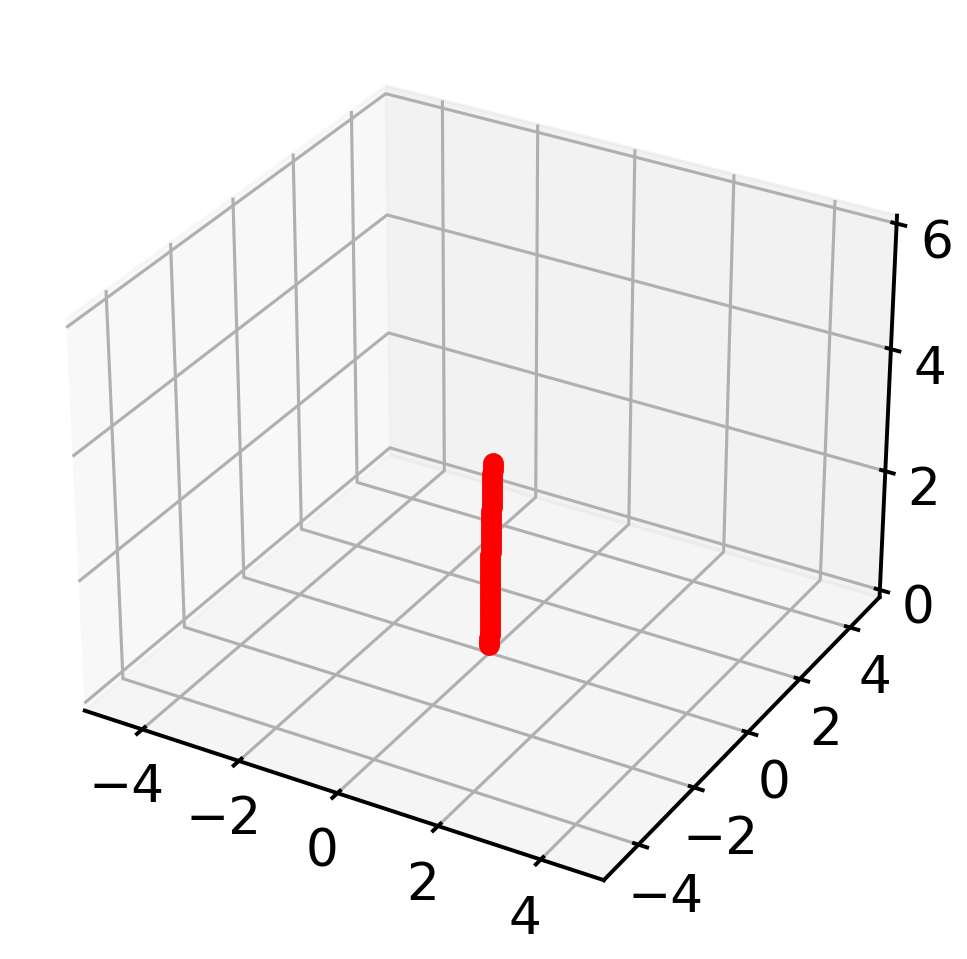

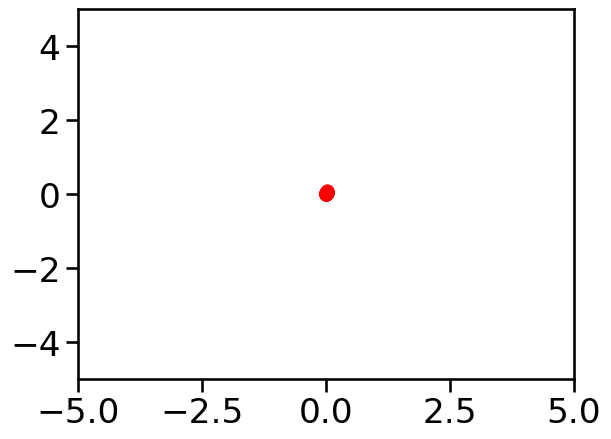

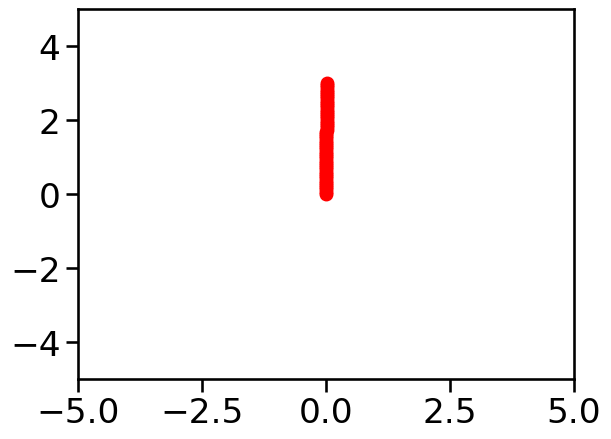

In [12]:
__doc__ = """Timoshenko beam validation case, for detailed explanation refer to
Gazzola et. al. R. Soc. 2018  section 3.4.3 """

class TimoshenkoBeamSimulator(
    ea.BaseSystemCollection, ea.Constraints, ea.Forcing, ea.CallBacks, ea.Damping
):
    pass


timoshenko_sim = TimoshenkoBeamSimulator()
final_time = 500.0 # lower time for easier sim -- change to 5000 for result plotting

# Options
PLOT_FIGURE = True
PLOT_VIDEO = True
SAVE_FIGURE = True
# SAVE_RESULTS = False
ADD_UNSHEARABLE_ROD = False

# setting up test params
n_elem = 50 #100
direction1 = np.array([0.0, 0.0, 1.0])
normal1 = np.array([0.0, 1.0, 0.0])
base_length = 3.0
base_radius = 0.25
base_area = np.pi * base_radius ** 2
startrod1 = np.zeros((3,))
density = 965 #kg/m^3
volume = base_length * np.pi*base_radius**2
nu = 1 #/ 7 / density / base_area
E = 1.32e6
mass = volume * density

# For shear modulus of 1e4, nu is 99!
poisson_ratio = 0.45
shear_modulus = E / (poisson_ratio + 1.0)

# Rod 1
rod1 = ea.CosseratRod.straight_rod(
    n_elem,
    startrod1,
    direction1,
    normal1,
    base_length,
    base_radius,
    density,
    youngs_modulus=E,
    shear_modulus=shear_modulus,
)
timoshenko_sim.append(rod1)

# add bc
timoshenko_sim.constrain(rod1).using(
    ea.OneEndFixedBC, constrained_position_idx=(0,), constrained_director_idx=(0,)
)

# add force
end_force = np.array([-50.0, 0.0, 0.0])

# Add forces to rod1
timoshenko_sim.add_forcing_to(rod1).using(
    EndpointForcesSin,
    start_force=0,
    end_force=end_force[0],
    ramp_up_time=0.2
)

# Beam parameters (should be changed)
length1 = 0.05
length2 = 0.05
length3 = 0.05
width1 = 0.05
width2 = 0.05
width3 = 0.05
height1 = 1
height2 = 1
height3 = 1

# Moment of Inertia
A1 = length1 * width1
A2 = length2 * width2
A3 = length3 * width3

Ix1 = (width1 * height1**3) / 12
Ix2 = (width2 * height2**3) / 12
Ix3 = (width3 * height3**3) / 12

Iy1 = (height1 * width1**3) / 12 + A1 * (height1 / 2 + height2 /2)**2
if (height2 - height2) == 0:
  Iy2 = (height2 * width2**3) / 12
else:
  Iy2 = (height2 * width2**3) / 12 + A2 * (height2 - height2 /2)**2
Iy3 = (height3 * width3**3) / 12 + A3 * (height3 / 2 + height2 /2)**2

d = width2 / 2 + width1 / 2

Iz1 = Ix1 + A1 * (d - width1/2)**2
Iz3 = Ix3 + A3 * (d - width2/2)**2
Iz2 = Ix2 #centroidal moment

Ix = Ix1 + Ix2 + Ix3
Iy = Iy1 + Iy2 + Iy3
Iz = Iz1 + Iz2 + Iz3

# print(Iz)

# Ix = 1
# Iy = 1
# Iz = 1

# Bend matrix changes
bend_1 = E*Ix
bend_2 = E*Iy
bend_3 = shear_modulus*Iz

print("Bend1:", rod1.bend_matrix)

rod1.bend_matrix[0, 0, :] = bend_1*np.ones(n_elem - 1)
rod1.bend_matrix[1, 1, :] = bend_2*np.ones(n_elem - 1)
rod1.bend_matrix[2, 2, :] = bend_3*np.ones(n_elem - 1)

print("Bend2:", rod1.bend_matrix)

# Shear matrix changes
alpha_c = 3/2 # for rectangle -- assume this shear correction factor for our I-beam

shear_1 = shear_modulus*base_area*alpha_c
shear_2 = shear_modulus*base_area*alpha_c
shear_3 = E*base_area

print("Shear1:", rod1.shear_matrix)

rod1.shear_matrix[0, 0, :] = shear_1*np.ones(n_elem)
rod1.shear_matrix[1, 1, :] = shear_2*np.ones(n_elem)
rod1.shear_matrix[2, 2, :] = shear_3*np.ones(n_elem)

print("Shear2:", rod1.shear_matrix)

# add damping
dl = base_length / n_elem
dt = 7e-3 * dl
timoshenko_sim.dampen(rod1).using(
    ea.AnalyticalLinearDamper,
    damping_constant=nu,
    time_step=dt,
)

analytical_cantilever_soln = AnalyticalDynamicCantilever(
        base_length,
        base_area,
        E,
        density,
        Iz, # about z direction, but maybe we want to make our own for 3D
        mode=0,
        end_velocity=0,
        )

initial_velocity = analytical_cantilever_soln.get_initial_velocity_profile(
        rod1.position_collection[0, :]
    )
rod1.velocity_collection[2, :] = initial_velocity

if ADD_UNSHEARABLE_ROD:
    # Start into the plane
    unshearable_start = np.array([0.0, -1.0, 0.0])
    shear_modulus = E / (-0.7 + 1.0)
    unrod1 = ea.CosseratRod.straight_rod(
        n_elem,
        unshearable_start,
        direction1,
        normal1,
        base_length,
        base_radius,
        density,
        youngs_modulus=E,
        # Unshearable rod needs G -> inf, which is achievable with -ve poisson ratio
        shear_modulus=shear_modulus,
    )

    timoshenko_sim.append(unrod1)

    # add damping
    timoshenko_sim.dampen(unrod1).using(
        ea.AnalyticalLinearDamper,
        damping_constant=nu,
        time_step=dt,
    )
    timoshenko_sim.constrain(unrod1).using(
        ea.OneEndFixedBC, constrained_position_idx=(0,), constrained_director_idx=(0,)
    )
    timoshenko_sim.add_forcing_to(unrod1).using(
        ea.EndpointForces, 0.0 * end_force, end_force, ramp_up_time=final_time / 2.0
    )

# Add call backs
class CantileverCallBack(ea.CallBackBaseClass):
    def __init__(self, step_skip: int, callback_params: dict):
        ea.CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params

    def make_callback(self, system, time, current_step: int):

        if current_step % self.every == 0:

            self.callback_params["time"].append(time)
            self.callback_params["position"].append(
                system.position_collection.copy()
            )
            self.callback_params["deflection"].append(
                system.position_collection[2, -1].copy()
            )
            return

deflection_history = ea.defaultdict(list)
timoshenko_sim.collect_diagnostics(rod1).using(
    CantileverCallBack, step_skip=500, callback_params=deflection_history
)

recorded_history = ea.defaultdict(list) # default dict for plotting
timoshenko_sim.collect_diagnostics(rod1).using(
    ea.MyCallBack, step_skip=500, callback_params=recorded_history
)

timoshenko_sim.finalize()
timestepper = ea.PositionVerlet()
# timestepper = PEFRL()

total_steps = int(final_time / dt)
print("Total steps", total_steps)
ea.integrate(timestepper, timoshenko_sim, final_time, total_steps)


if PLOT_FIGURE:
    plot_timoshenko(rod1, end_force, SAVE_FIGURE, ADD_UNSHEARABLE_ROD)

# if SAVE_RESULTS:
#     import pickle

#     filename = "Timoshenko_beam_data.dat"
#     file = open(filename, "wb")
#     pickle.dump(rod1, file)
#     file.close()

#     tv = (
#         np.asarray(recorded_history["time"]),
#         np.asarray(recorded_history["velocity_norms"]),
#     )

#     def as_time_series(v):
#         return v.T

#     np.savetxt(
#         "velocity_norms.csv",
#         as_time_series(np.stack(tv)),
#         delimiter=",",
#     )

if PLOT_VIDEO:
    filename = "timoshenko_I_beam.mp4"
    plot_video(recorded_history, video_name=filename, margin=0.2, fps=100)
    plot_video_xy(
        recorded_history, video_name=filename + "_xy.mp4", margin=0.2, fps=100
    )
    plot_video_xz(
        recorded_history, video_name=filename + "_xz.mp4", margin=0.2, fps=100
    )

# Main Code - I Beam for CMA

In [23]:
__doc__ = """Timoshenko beam validation case, for detailed explanation refer to
Gazzola et. al. R. Soc. 2018  section 3.4.3 """

class TimoshenkoBeamSimulator(
    ea.BaseSystemCollection, ea.Constraints, ea.Forcing, ea.CallBacks, ea.Damping
):
    pass

def simulateIBeam(length1, length2, length3, width1, width2, width3, height1, height2, height3, end_force):
  timoshenko_sim = TimoshenkoBeamSimulator()
  final_time = 50.0 # lower time for easier sim -- change to 5000 for result plotting

  # Diane's Test Parameters
  # setting up test params
  n_elem = 50 #100
  direction1 = np.array([0.0, 0.0, 1.0])
  normal1 = np.array([0.0, 1.0, 0.0])
  base_length = 3.0
  base_radius = 0.25
  base_area = np.pi * base_radius ** 2
  startrod1 = np.zeros((3,))
  density = 965 #kg/m^3
  volume = base_length * np.pi*base_radius**2
  nu = 1 #/ 7 / density / base_area
  E = 1.32e6
  mass = volume * density

  # For shear modulus of 1e4, nu is 99!
  poisson_ratio = 0.45
  shear_modulus = E / (poisson_ratio + 1.0)

  # Rod 1
  rod1 = ea.CosseratRod.straight_rod(
      n_elem,
      startrod1,
      direction1,
      normal1,
      base_length,
      base_radius,
      density,
      youngs_modulus=E,
      shear_modulus=shear_modulus,
  )
  timoshenko_sim.append(rod1)

  # add bc
  timoshenko_sim.constrain(rod1).using(
      ea.OneEndFixedBC, constrained_position_idx=(0,), constrained_director_idx=(0,)
  )

  # add force

  # Add forces to rod1
  timoshenko_sim.add_forcing_to(rod1).using(
      EndpointForcesSin,
      start_force=0,
      end_force=end_force[0],
      ramp_up_time=0.2
  )

  Iz = replaceBendMatrix(rod1, E, shear_modulus, n_elem, length1, length2, length3, width1, width2, width3, height1, height2, height3)

  replaceShearMatrix(rod1, shear_modulus, E, base_area, n_elem)

  # add damping
  dl = base_length / n_elem
  dt = 7e-3 * dl
  timoshenko_sim.dampen(rod1).using(
      ea.AnalyticalLinearDamper,
      damping_constant=nu,
      time_step=dt,
  )

  analytical_cantilever_soln = AnalyticalDynamicCantilever(
          base_length,
          base_area,
          E,
          density,
          Iz, # about z direction, but maybe we want to make our own for 3D
          mode=0,
          end_velocity=0,
          )

  initial_velocity = analytical_cantilever_soln.get_initial_velocity_profile(
          rod1.position_collection[0, :]
      )
  rod1.velocity_collection[2, :] = initial_velocity

  deflection_history = ea.defaultdict(list)
  timoshenko_sim.collect_diagnostics(rod1).using(
      CantileverCallBack, step_skip=500, callback_params=deflection_history
  )

  recorded_history = ea.defaultdict(list) # default dict for plotting
  timoshenko_sim.collect_diagnostics(rod1).using(
      ea.MyCallBack, step_skip=500, callback_params=recorded_history
  )

  timoshenko_sim.finalize()
  timestepper = ea.PositionVerlet()
  # timestepper = PEFRL()

  total_steps = int(final_time / dt)
  print("Total steps", total_steps)
  ea.integrate(timestepper, timoshenko_sim, final_time, total_steps)

  return 1e3*abs(base_length*np.ones(len(deflection_history["deflection"])) - deflection_history["deflection"])
  # return deflection_history["deflection"], deflection_history["time"]

def replaceBendMatrix(rod1, E, shear_modulus, n_elem, length1, length2, length3, width1, width2, width3, height1, height2, height3):

  # Moment of Inertia
  A1 = length1 * width1
  A2 = length2 * width2
  A3 = length3 * width3

  Ix1 = (width1 * height1**3) / 12
  Ix2 = (width2 * height2**3) / 12
  Ix3 = (width3 * height3**3) / 12

  Iy1 = (height1 * width1**3) / 12 + A1 * (height1 / 2 + height2 /2)**2
  if (height2 - height2) == 0:
    Iy2 = (height2 * width2**3) / 12
  else:
    Iy2 = (height2 * width2**3) / 12 + A2 * (height2 - height2 /2)**2
  Iy3 = (height3 * width3**3) / 12 + A3 * (height3 / 2 + height2 /2)**2

  d = width2 / 2 + width1 / 2

  Iz1 = Ix1 + A1 * (d - width1/2)**2
  Iz3 = Ix3 + A3 * (d - width2/2)**2
  Iz2 = Ix2 #centroidal moment

  Ix = Ix1 + Ix2 + Ix3
  Iy = Iy1 + Iy2 + Iy3
  Iz = Iz1 + Iz2 + Iz3

  # Bend matrix changes
  bend_1 = E*Ix
  bend_2 = E*Iy
  bend_3 = shear_modulus*Iz

  # print("Bend1:", rod1.bend_matrix)

  rod1.bend_matrix[0, 0, :] = bend_1*np.ones(n_elem - 1)
  rod1.bend_matrix[1, 1, :] = bend_2*np.ones(n_elem - 1)
  rod1.bend_matrix[2, 2, :] = bend_3*np.ones(n_elem - 1)

  # print("Bend2:", rod1.bend_matrix)

  return Iz

def replaceShearMatrix(rod1, shear_modulus, E, base_area, n_elem):
  # Shear matrix changes
  alpha_c = 3/2 # for rectangle -- assume this shear correction factor for our I-beam

  shear_1 = shear_modulus*base_area*alpha_c
  shear_2 = shear_modulus*base_area*alpha_c
  shear_3 = E*base_area

  # print("Shear1:", rod1.shear_matrix)

  rod1.shear_matrix[0, 0, :] = shear_1*np.ones(n_elem)
  rod1.shear_matrix[1, 1, :] = shear_2*np.ones(n_elem)
  rod1.shear_matrix[2, 2, :] = shear_3*np.ones(n_elem)

  # print("Shear2:", rod1.shear_matrix)

# Add call backs
class CantileverCallBack(ea.CallBackBaseClass):
    def __init__(self, step_skip: int, callback_params: dict):
        ea.CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params

    def make_callback(self, system, time, current_step: int):

        if current_step % self.every == 0:

            self.callback_params["time"].append(time)
            self.callback_params["position"].append(
                system.position_collection.copy()
            )
            self.callback_params["deflection"].append(
                system.position_collection[2, -1].copy()
            )
            return

In [25]:
absDeflection = simulateIBeam(0.10626693, 0.13740347, 0.06279292, 0.04815774, 0.28413183, 0.24709457,
 0.89521126, 0.96145176, 0.57799472, [-50.0, 0.0, 0.0])

Total steps 119047


100%|██████████| 119047/119047 [00:17<00:00, 6697.04it/s]

Final time of simulation is :  50.00000000027868


239
-0.6967868536440491


Text(0, 0.5, 'Relative Deformation (x10e-3)')

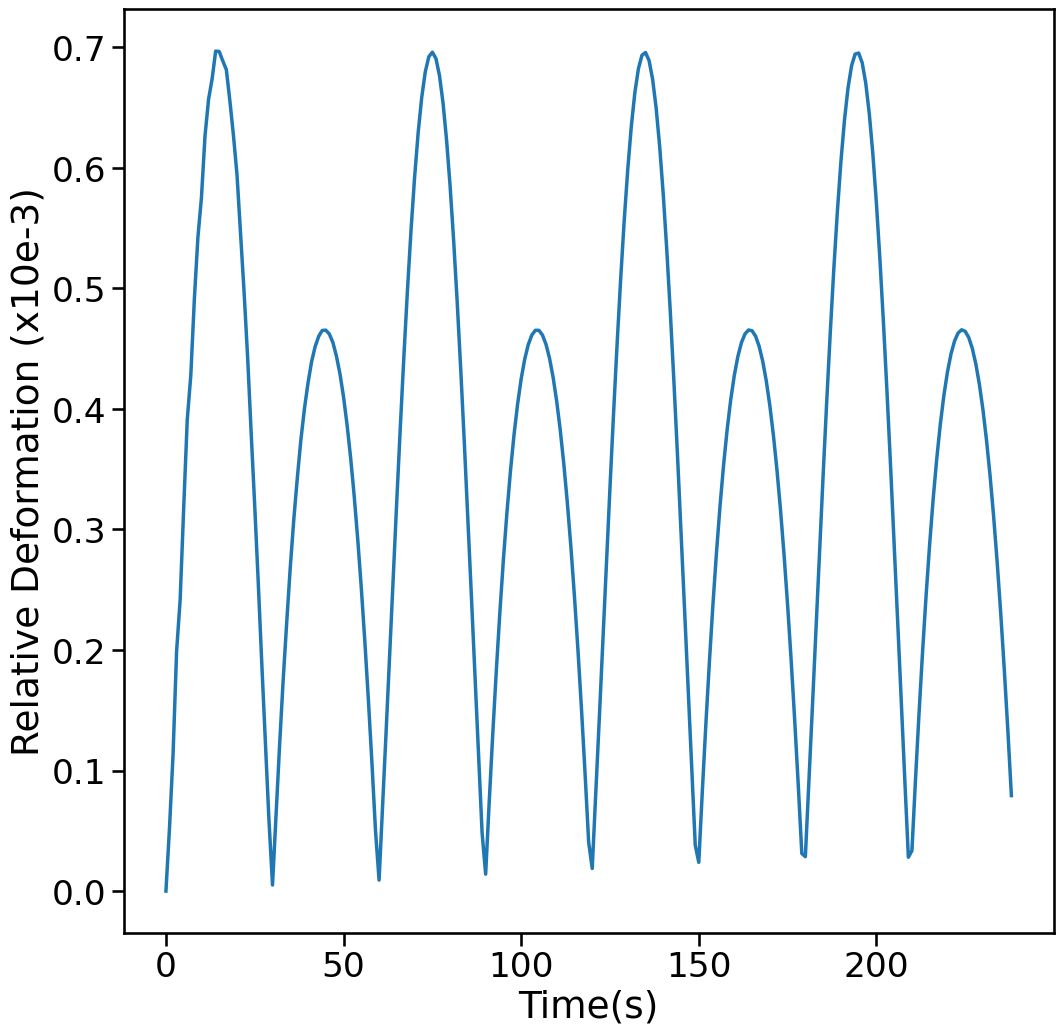

In [26]:
# plt.plot(absDeflection[-100:len(absDeflection)])
plt.figure(figsize=(12,12))
plt.plot(absDeflection)
print(len(absDeflection))
print(-max(absDeflection))
plt.xlabel("Time(s)")
plt.ylabel("Relative Deformation (x10e-3)")

# CMA

In [21]:
import numpy as np
from numpy.random import multivariate_normal
from tqdm import tqdm
import copy

class CMAES:
    """Naive CMA implementation"""

    def __init__(self, initial_mean, sigma, popsize, generations_to_run, **kwargs):
        self.centroid = np.asarray(initial_mean).copy()
        self.sigma = sigma
        self.pc = np.zeros_like(initial_mean)
        self.ps = np.zeros_like(initial_mean)
        self.C = np.eye(initial_mean.shape[0])
        self.B = np.eye(self.C.shape[0])
        self.diagD = np.ones(initial_mean.shape[0])

        # Optimal popsize
        self.popsize = popsize
        self.mu = popsize // 5
        # Update weights later on
        # Constant weight policy
        # self.weights = np.ones((self.mu, )) / self.mu

        # Decreasing weight policy
        self.weights = np.arange(self.mu, 0.0, -1.0)
        self.weights /= np.sum(self.weights)

        # Negative, Positive weight policy
        # unscaled_weights = np.arange(1.0 ,  1.0 + popsize)
        # unscaled_weights = np.log(0.5 * (popsize + 1.0) / unscaled_weights)

        # Utility variables
        self.dim = initial_mean.shape[0]

        # Expectation of a normal distribution
        self.chiN = np.sqrt(self.dim) * (1.0 - 0.25 / self.dim + 1.0/(21.0 * self.dim**2))
        self.mueff = 1.0 / np.linalg.norm(self.weights, 2)**2
        self.generations = 0

        # Options
        self.generations_to_run = generations_to_run
        # Sigma adaptation
        # cs is short for c_sigma
        self.cs = kwargs.get("cs", (2.0 + self.mueff) / (self.dim + self.mueff + 5.0))
        # ds is short for d_sigma
        self.ds = 1.0 + 2.0 * max(0.0, np.sqrt((self.mueff - 1.0)/ (self.dim + 1.0)) - 1.0) + self.cs

        # Covariance adaptation
        self.cc = kwargs.get("cc", (4.0 + self.mueff/self.dim) / (self.dim + 4.0 + 2.0 * self.mueff/self.dim))
        self.ccov = 0.0
        # If implementing the latest version of CMA according to the tutorial,
        # these parameters can be useful
        self.ccov1 = 2.0 / ((self.dim + 1.3)**2 + self.mueff)
        self.ccovmu = min(1.0 - self.ccov1, 2.0 * (self.mueff - 2.0 + 1.0/self.mueff)/((self.dim + 2.0)**2 + self.mueff))

        # Create an array to store fitness values
        self.fitness = np.zeros((self.generations_to_run, 1)) # edit!

        self.stats_centroids = []
        self.stats_new_centroids = []
        self.stats_covs = []
        self.stats_new_covs = []
        self.stats_offspring = []
        self.stats_offspring_weights = []
        self.stats_ps = []

    def update(self, problem, population):
         # -- store current state of the algorithm
        self.stats_centroids.append(copy.deepcopy(self.centroid))
        self.stats_covs.append(copy.deepcopy(self.C))

        pop_fitness = np.zeros(self.popsize)

        for idx in range(self.popsize):
          pop_fitness[idx] = problem.calc_fitness(population[idx])
          print(f'{idx} of {self.popsize} in generation')

        print(pop_fitness)
        index = np.argsort(pop_fitness)
        print(index[::-1])
        population = population[index[::-1]]
        print(population)
        # population.sort(key=lambda ind: problem(ind[0], ind[1]))
        # population.sort(key=problem)

        # -- store sorted offspring
        self.stats_offspring.append(copy.deepcopy(population))

        old_centroid = self.centroid
        # Note : the following does m <- <x>_w
        # Note : this is equivalent to doing m <- m + sigma * <z>_w
        # as x = m + sigma * z provided the weights sum to 1.0 which it
        # does
        self.centroid = np.dot(self.weights, population[0:self.mu])

        # -- store new centroid
        self.stats_new_centroids.append(copy.deepcopy(self.centroid))

        c_diff = self.centroid - old_centroid

        # Cumulation : update evolution path
        # Equivalent to in-class definition
        self.ps = (1 - self.cs) * self.ps \
             + np.sqrt(self.cs * (2 - self.cs) * self.mueff) / self.sigma \
             * np.dot(self.B, (1. / self.diagD) * np.dot(self.B.T, c_diff))

        # -- store new evol path
        self.stats_ps.append(copy.deepcopy(self.ps))

        hsig = float((np.linalg.norm(self.ps) /
                np.sqrt(1. - (1. - self.cs)**(2. * (self.generations + 1.))) / self.chiN
                < (1.4 + 2. / (self.dim + 1.))))

        self.pc = (1 - self.cc) * self.pc + hsig \
                  * np.sqrt(self.cc * (2 - self.cc) * self.mueff) / self.sigma \
                  * c_diff

        # Update covariance matrix
        artmp = population[0:self.mu] - old_centroid
        self.C = (1 - self.ccov1 - self.ccovmu + (1 - hsig) \
                   * self.ccov1 * self.cc * (2 - self.cc)) * self.C \
                + self.ccov1 * np.outer(self.pc, self.pc) \
                + self.ccovmu * np.dot((self.weights * artmp.T), artmp) \
                / self.sigma**2

        # -- store new covs
        self.stats_new_covs.append(copy.deepcopy(self.C))

        self.sigma *= np.exp((np.linalg.norm(self.ps) / self.chiN - 1.) \
                                * self.cs / self.ds)

        self.diagD, self.B = np.linalg.eigh(self.C)
        indx = np.argsort(self.diagD)

        self.cond = self.diagD[indx[-1]]/self.diagD[indx[0]]

        self.diagD = self.diagD[indx]**0.5
        self.B = self.B[:, indx]
        self.BD = self.B * self.diagD

        return population

    def run(self, problem):
        self.reset()  # Reset statistics
        for i in tqdm(range(self.generations_to_run)):

            population = list(multivariate_normal(self.centroid, self.sigma**2 * self.C, self.popsize))
            population = np.array(population)
            print("Pre-Run Population:", population)
            population = self.update(problem, population)
            print("Post-Run Population:", population)
            self.fitness[self.generations] = problem.calc_fitness(population[0])
            self.generations += 1
            print(f"generation {self.generations}")
            print(f'current best: {population[0]}')
            print(f'fitness: {self.fitness}')
        return population[0], self.fitness

    def reset(self):
        # Clears everything to rerun the problem
        self.stats_centroids = []
        self.stats_new_centroids = []
        self.stats_covs = []
        self.stats_new_covs = []
        self.stats_offspring = []
        self.stats_offspring_weights = []
        self.stats_ps = []

class IBeamDeformationProblem:
    def __init__(self, beam_properties, end_force):
        self.beam_properties = beam_properties
        self.end_force = end_force

    def calc_fitness(self, population):
        length1, length2, length3, width1, width2, width3, height1, height2, height3 = population

        deformation_response = simulateIBeam(length1, length2, length3, width1, width2, width3, height1, height2, height3, self.end_force) # returns abs number
        # print(deformation_response)
        fitness = -max(deformation_response)

        print(fitness)

        if fitness == -0:
          fitness = -100 # catches the case of exploding model

        boundary = 0
        penalty = 10
        vars = np.array([length1, length2, length3, width1, width2, width3, height1, height2, height3])

        print(vars)

        print(np.where(vars <= boundary))

        print(np.any(vars <= boundary))

        if np.any(vars <= boundary):
            for idx in np.where(vars <= boundary):
                print(vars[idx])
                fitness -= abs(min(vars[idx] * penalty))

        print(fitness)

        return fitness


initial_width1 = 0.05
initial_width2 = 0.05
initial_width3 = 0.05

initial_height1 = 1
initial_height2 = 1
initial_height3 = 1

initial_length1 = 0.05
initial_length2 = 0.05
initial_length3 = 0.05


initial_mean = np.array([initial_length1, initial_length2, initial_length3, initial_width1, initial_width2, initial_width3, initial_height1, initial_height2, initial_height3])

beam_properties = {
    'length1': initial_length1,
    'length2': initial_length2,
    'length3': initial_length3,
    'width1': initial_width1,
    'width2': initial_width2,
    'width3': initial_width3,
    'height1': initial_height1,
    'height2': initial_height2,
    'height3': initial_height3
}

end_force = np.array([-50, 0.0, 0.0])
sigma = 0.07
pop_size = 5
gen = 15

ibeam_optimization = CMAES(initial_mean=initial_mean, sigma=sigma, popsize=pop_size, generations_to_run=gen)
ibeam_problem = IBeamDeformationProblem(beam_properties, end_force)

# Run the optimization
best_solution, fitnesses = ibeam_optimization.run(ibeam_problem)

  0%|          | 0/15 [00:00<?, ?it/s]<ipython-input-3-7d2809340a12>:77: RuntimeWarning: invalid value encountered in sqrt
  self.omega = (self.beta ** 2) * np.sqrt(


Pre-Run Population: [[ 0.02690709 -0.03138275  0.12185432 -0.099905    0.0032547  -0.00375353
   0.86521774  1.14769043  1.003749  ]
 [ 0.03033681  0.05937654  0.10016875  0.01921906  0.08935622 -0.05438067
   0.90267995  1.08976843  1.08850076]
 [ 0.02318439  0.15032348 -0.03941592  0.08703751  0.02268091  0.02132475
   1.07919929  0.95471706  1.01775788]
 [ 0.13676928  0.03142238  0.05470752 -0.09961842  0.05346296  0.08378253
   0.93155197  0.94568262  0.99645063]
 [ 0.11801651 -0.02761608 -0.05229235  0.1064898  -0.00149788  0.09599027
   0.91966596  1.05946262  0.89894839]]
Total steps 119047



100%|██████████| 119047/119047 [00:16<00:00, 7077.79it/s]


Final time of simulation is :  50.00000000027868
-0.0
[ 0.02690709 -0.03138275  0.12185432 -0.099905    0.0032547  -0.00375353
  0.86521774  1.14769043  1.003749  ]
(array([1, 3, 5]),)
True
[-0.03138275 -0.099905   -0.00375353]
-100.99905002632546
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:16<00:00, 7360.72it/s]


Final time of simulation is :  50.00000000027868
-0.0
[ 0.03033681  0.05937654  0.10016875  0.01921906  0.08935622 -0.05438067
  0.90267995  1.08976843  1.08850076]
(array([5]),)
True
[-0.05438067]
-100.54380672462908
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:16<00:00, 7100.66it/s]


Final time of simulation is :  50.00000000027868
-15.422499618911623
[ 0.02318439  0.15032348 -0.03941592  0.08703751  0.02268091  0.02132475
  1.07919929  0.95471706  1.01775788]
(array([2]),)
True
[-0.03941592]
-15.816658839846353
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:16<00:00, 7226.90it/s]


Final time of simulation is :  50.00000000027868
-0.0
[ 0.13676928  0.03142238  0.05470752 -0.09961842  0.05346296  0.08378253
  0.93155197  0.94568262  0.99645063]
(array([3]),)
True
[-0.09961842]
-100.99618415231255
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:17<00:00, 6885.82it/s]


Final time of simulation is :  50.00000000027868
-1.1360708195775615
[ 0.11801651 -0.02761608 -0.05229235  0.1064898  -0.00149788  0.09599027
  0.91966596  1.05946262  0.89894839]
(array([1, 2, 4]),)
True
[-0.02761608 -0.05229235 -0.00149788]
-1.6589943469835688
4 of 5 in generation
[-100.99905003 -100.54380672  -15.81665884 -100.99618415   -1.65899435]
[4 2 1 3 0]
[[ 0.11801651 -0.02761608 -0.05229235  0.1064898  -0.00149788  0.09599027
   0.91966596  1.05946262  0.89894839]
 [ 0.02318439  0.15032348 -0.03941592  0.08703751  0.02268091  0.02132475
   1.07919929  0.95471706  1.01775788]
 [ 0.03033681  0.05937654  0.10016875  0.01921906  0.08935622 -0.05438067
   0.90267995  1.08976843  1.08850076]
 [ 0.13676928  0.03142238  0.05470752 -0.09961842  0.05346296  0.08378253
   0.93155197  0.94568262  0.99645063]
 [ 0.02690709 -0.03138275  0.12185432 -0.099905    0.0032547  -0.00375353
   0.86521774  1.14769043  1.003749  ]]
Post-Run Population: [[ 0.11801651 -0.02761608 -0.05229235  0.1064


  7%|▋         | 1/15 [01:41<23:41, 101.51s/it]

Final time of simulation is :  50.00000000027868
-1.1360708195775615
[ 0.11801651 -0.02761608 -0.05229235  0.1064898  -0.00149788  0.09599027
  0.91966596  1.05946262  0.89894839]
(array([1, 2, 4]),)
True
[-0.02761608 -0.05229235 -0.00149788]
-1.6589943469835688
generation 1
current best: [ 0.11801651 -0.02761608 -0.05229235  0.1064898  -0.00149788  0.09599027
  0.91966596  1.05946262  0.89894839]
fitness: [[-1.65899435]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Pre-Run Population: [[ 0.16817777  0.03154858 -0.0143953   0.08789837  0.03795774  0.02074904
   0.92493044  1.06654884  0.83062654]
 [ 0.21830086 -0.02955632 -0.01807377  0.16137381 -0.00963439  0.06077785
   0.88761849  1.12263574  0.9396949 ]
 [ 0.19308966 -0.05090455 -0.13385479  0.13533122 -0.10998886  0.11618654
   0.88623534  1.07867841  0.83157342]
 [ 0.


100%|██████████| 119047/119047 [00:17<00:00, 6796.30it/s]


Final time of simulation is :  50.00000000027868
-0.9017643535726982
[ 0.16817777  0.03154858 -0.0143953   0.08789837  0.03795774  0.02074904
  0.92493044  1.06654884  0.83062654]
(array([2]),)
True
[-0.0143953]
-1.0457173214910818
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:17<00:00, 6813.55it/s]


Final time of simulation is :  50.00000000027868
-0.7511653523035733
[ 0.21830086 -0.02955632 -0.01807377  0.16137381 -0.00963439  0.06077785
  0.88761849  1.12263574  0.9396949 ]
(array([1, 2, 4]),)
True
[-0.02955632 -0.01807377 -0.00963439]
-1.0467285753595574
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:18<00:00, 6547.85it/s]


Final time of simulation is :  50.00000000027868
-8.25924965574476
[ 0.19308966 -0.05090455 -0.13385479  0.13533122 -0.10998886  0.11618654
  0.88623534  1.07867841  0.83157342]
(array([1, 2, 4]),)
True
[-0.05090455 -0.13385479 -0.10998886]
-9.597797508328517
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:17<00:00, 6836.36it/s]


Final time of simulation is :  50.00000000027868
-0.7696673950312594
[ 0.138457    0.01958882 -0.05770851  0.13863719  0.08746591  0.09981338
  0.86908725  1.07957073  0.97499479]
(array([2]),)
True
[-0.05770851]
-1.3467524828978492
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:17<00:00, 6675.77it/s]


Final time of simulation is :  50.00000000027868
-0.9000636930709405
[ 0.18090763 -0.08682446 -0.06362331  0.14368571 -0.08194096  0.1139854
  0.92360627  0.98551674  0.89816046]
(array([1, 2, 4]),)
True
[-0.08682446 -0.06362331 -0.08194096]
-1.7683082449382412
4 of 5 in generation
[-1.04571732 -1.04672858 -9.59779751 -1.34675248 -1.76830824]
[0 1 3 4 2]
[[ 0.16817777  0.03154858 -0.0143953   0.08789837  0.03795774  0.02074904
   0.92493044  1.06654884  0.83062654]
 [ 0.21830086 -0.02955632 -0.01807377  0.16137381 -0.00963439  0.06077785
   0.88761849  1.12263574  0.9396949 ]
 [ 0.138457    0.01958882 -0.05770851  0.13863719  0.08746591  0.09981338
   0.86908725  1.07957073  0.97499479]
 [ 0.18090763 -0.08682446 -0.06362331  0.14368571 -0.08194096  0.1139854
   0.92360627  0.98551674  0.89816046]
 [ 0.19308966 -0.05090455 -0.13385479  0.13533122 -0.10998886  0.11618654
   0.88623534  1.07867841  0.83157342]]
Post-Run Population: [[ 0.16817777  0.03154858 -0.0143953   0.08789837  0.0379


 13%|█▎        | 2/15 [03:27<22:34, 104.22s/it]

Final time of simulation is :  50.00000000027868
-0.9017643535726982
[ 0.16817777  0.03154858 -0.0143953   0.08789837  0.03795774  0.02074904
  0.92493044  1.06654884  0.83062654]
(array([2]),)
True
[-0.0143953]
-1.0457173214910818
generation 2
current best: [ 0.16817777  0.03154858 -0.0143953   0.08789837  0.03795774  0.02074904
  0.92493044  1.06654884  0.83062654]
fitness: [[-1.65899435]
 [-1.04571732]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Pre-Run Population: [[ 0.19615993  0.03945011 -0.03971495  0.04326311 -0.0807561   0.10443005
   0.89397664  1.08226209  0.7399309 ]
 [ 0.21692232  0.08120913 -0.06084239  0.16213421  0.01280301 -0.06986115
   1.0084552   1.05108152  0.84376466]
 [ 0.16823102  0.16291396  0.08906526  0.04640443  0.0943742   0.02358906
   0.96382315  1.08391319  0.83467023]
 [ 0.1054922  -0.05958728 -0.0169574


100%|██████████| 119047/119047 [00:17<00:00, 6884.22it/s]


Final time of simulation is :  50.00000000027868
-0.0
[ 0.19615993  0.03945011 -0.03971495  0.04326311 -0.0807561   0.10443005
  0.89397664  1.08226209  0.7399309 ]
(array([2, 4]),)
True
[-0.03971495 -0.0807561 ]
-100.80756101940605
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:17<00:00, 6709.41it/s]


Final time of simulation is :  50.00000000027868
-0.7689010881271052
[ 0.21692232  0.08120913 -0.06084239  0.16213421  0.01280301 -0.06986115
  1.0084552   1.05108152  0.84376466]
(array([2, 5]),)
True
[-0.06084239 -0.06986115]
-1.4675126280836
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:17<00:00, 6728.18it/s]


Final time of simulation is :  50.00000000027868
-0.9157215359665294
[0.16823102 0.16291396 0.08906526 0.04640443 0.0943742  0.02358906
 0.96382315 1.08391319 0.83467023]
(array([], dtype=int64),)
False
-0.9157215359665294
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:18<00:00, 6480.62it/s]


Final time of simulation is :  50.00000000027868
-0.6574932171972137
[ 0.1054922  -0.05958728 -0.01695748  0.17355555  0.10019836  0.07984981
  0.98361277  1.17268202  0.76351033]
(array([1, 2]),)
True
[-0.05958728 -0.01695748]
-1.2533659808530966
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:18<00:00, 6378.62it/s]


Final time of simulation is :  50.00000000027868
-0.7175030676274119
[ 0.19799663  0.10654128 -0.02457245  0.11679682  0.0509604   0.06479823
  0.92739791  1.06477329  0.83038923]
(array([2]),)
True
[-0.02457245]
-0.9632276088158027
4 of 5 in generation
[-100.80756102   -1.46751263   -0.91572154   -1.25336598   -0.96322761]
[2 4 3 1 0]
[[ 0.16823102  0.16291396  0.08906526  0.04640443  0.0943742   0.02358906
   0.96382315  1.08391319  0.83467023]
 [ 0.19799663  0.10654128 -0.02457245  0.11679682  0.0509604   0.06479823
   0.92739791  1.06477329  0.83038923]
 [ 0.1054922  -0.05958728 -0.01695748  0.17355555  0.10019836  0.07984981
   0.98361277  1.17268202  0.76351033]
 [ 0.21692232  0.08120913 -0.06084239  0.16213421  0.01280301 -0.06986115
   1.0084552   1.05108152  0.84376466]
 [ 0.19615993  0.03945011 -0.03971495  0.04326311 -0.0807561   0.10443005
   0.89397664  1.08226209  0.7399309 ]]
Post-Run Population: [[ 0.16823102  0.16291396  0.08906526  0.04640443  0.0943742   0.02358906
 


 20%|██        | 3/15 [05:16<21:16, 106.40s/it]

Final time of simulation is :  50.00000000027868
-0.9157215359665294
[0.16823102 0.16291396 0.08906526 0.04640443 0.0943742  0.02358906
 0.96382315 1.08391319 0.83467023]
(array([], dtype=int64),)
False
-0.9157215359665294
generation 3
current best: [0.16823102 0.16291396 0.08906526 0.04640443 0.0943742  0.02358906
 0.96382315 1.08391319 0.83467023]
fitness: [[-1.65899435]
 [-1.04571732]
 [-0.91572154]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Pre-Run Population: [[ 0.11762645  0.19173741  0.07038222  0.08768192  0.16292295  0.09571293
   0.91070505  1.08867714  0.8553193 ]
 [ 0.14614786  0.14929747  0.03406655 -0.07248939  0.07784043  0.0295975
   1.00882074  0.99829256  0.90316314]
 [ 0.15346777  0.22403077  0.02484967  0.04222087  0.04553031  0.03330523
   0.97071546  1.2065399   0.83878179]
 [ 0.08058525  0.17633331  0.04382078  0.03244939  0.16


100%|██████████| 119047/119047 [00:18<00:00, 6362.96it/s]


Final time of simulation is :  50.00000000027868
-0.6857997406153338
[0.11762645 0.19173741 0.07038222 0.08768192 0.16292295 0.09571293
 0.91070505 1.08867714 0.8553193 ]
(array([], dtype=int64),)
False
-0.6857997406153338
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:18<00:00, 6549.62it/s]


Final time of simulation is :  50.00000000027868
-0.0
[ 0.14614786  0.14929747  0.03406655 -0.07248939  0.07784043  0.0295975
  1.00882074  0.99829256  0.90316314]
(array([3]),)
True
[-0.07248939]
-100.72489394921556
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:18<00:00, 6441.91it/s]


Final time of simulation is :  50.00000000027868
-1.0797498833756691
[0.15346777 0.22403077 0.02484967 0.04222087 0.04553031 0.03330523
 0.97071546 1.2065399  0.83878179]
(array([], dtype=int64),)
False
-1.0797498833756691
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:18<00:00, 6427.05it/s]


Final time of simulation is :  50.00000000027868
-2.121068996399078
[0.08058525 0.17633331 0.04382078 0.03244939 0.1602221  0.02282881
 0.9351764  1.12937481 0.83898342]
(array([], dtype=int64),)
False
-2.121068996399078
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:18<00:00, 6477.24it/s]


Final time of simulation is :  50.00000000027868
-2.832504580111639
[ 0.14064719  0.24530587  0.08441325  0.03186104  0.02065347 -0.00290692
  0.97821304  1.11087829  0.72312427]
(array([5]),)
True
[-0.00290692]
-2.8615737971145476
4 of 5 in generation
[  -0.68579974 -100.72489395   -1.07974988   -2.121069     -2.8615738 ]
[0 2 3 4 1]
[[ 0.11762645  0.19173741  0.07038222  0.08768192  0.16292295  0.09571293
   0.91070505  1.08867714  0.8553193 ]
 [ 0.15346777  0.22403077  0.02484967  0.04222087  0.04553031  0.03330523
   0.97071546  1.2065399   0.83878179]
 [ 0.08058525  0.17633331  0.04382078  0.03244939  0.1602221   0.02282881
   0.9351764   1.12937481  0.83898342]
 [ 0.14064719  0.24530587  0.08441325  0.03186104  0.02065347 -0.00290692
   0.97821304  1.11087829  0.72312427]
 [ 0.14614786  0.14929747  0.03406655 -0.07248939  0.07784043  0.0295975
   1.00882074  0.99829256  0.90316314]]
Post-Run Population: [[ 0.11762645  0.19173741  0.07038222  0.08768192  0.16292295  0.09571293
   


 27%|██▋       | 4/15 [07:07<19:51, 108.36s/it]

Final time of simulation is :  50.00000000027868
-0.6857997406153338
[0.11762645 0.19173741 0.07038222 0.08768192 0.16292295 0.09571293
 0.91070505 1.08867714 0.8553193 ]
(array([], dtype=int64),)
False
-0.6857997406153338
generation 4
current best: [0.11762645 0.19173741 0.07038222 0.08768192 0.16292295 0.09571293
 0.91070505 1.08867714 0.8553193 ]
fitness: [[-1.65899435]
 [-1.04571732]
 [-0.91572154]
 [-0.68579974]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Pre-Run Population: [[0.14067382 0.17418958 0.14680785 0.11123396 0.21608169 0.04490121
  0.94790582 1.0660719  0.86628741]
 [0.14385704 0.18983737 0.00532217 0.11122137 0.09919946 0.1420964
  0.94331318 0.93622479 0.87620732]
 [0.17527144 0.20562871 0.05580693 0.11426902 0.24219672 0.07562016
  0.90644514 1.04105184 0.75002444]
 [0.18170274 0.13141926 0.04459158 0.08847718 0.1725178  0.05195586
  0.92405873 1


100%|██████████| 119047/119047 [00:19<00:00, 6199.34it/s]


Final time of simulation is :  50.00000000027868
-0.643484547058204
[0.14067382 0.17418958 0.14680785 0.11123396 0.21608169 0.04490121
 0.94790582 1.0660719  0.86628741]
(array([], dtype=int64),)
False
-0.643484547058204
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:19<00:00, 6025.82it/s]


Final time of simulation is :  50.00000000027868
-0.7246172803374584
[0.14385704 0.18983737 0.00532217 0.11122137 0.09919946 0.1420964
 0.94331318 0.93622479 0.87620732]
(array([], dtype=int64),)
False
-0.7246172803374584
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:20<00:00, 5913.72it/s]


Final time of simulation is :  50.00000000027868
-0.6403953881459756
[0.17527144 0.20562871 0.05580693 0.11426902 0.24219672 0.07562016
 0.90644514 1.04105184 0.75002444]
(array([], dtype=int64),)
False
-0.6403953881459756
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:19<00:00, 6051.36it/s]


Final time of simulation is :  50.00000000027868
-0.6620942675761299
[0.18170274 0.13141926 0.04459158 0.08847718 0.1725178  0.05195586
 0.92405873 1.1337768  0.8756864 ]
(array([], dtype=int64),)
False
-0.6620942675761299
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:19<00:00, 6244.33it/s]


Final time of simulation is :  50.00000000027868
-0.7126104873940164
[0.1181505  0.21827571 0.06901232 0.06218684 0.17244924 0.10913579
 0.80202531 1.11859394 0.87600836]
(array([], dtype=int64),)
False
-0.7126104873940164
4 of 5 in generation
[-0.64348455 -0.72461728 -0.64039539 -0.66209427 -0.71261049]
[2 0 3 4 1]
[[0.17527144 0.20562871 0.05580693 0.11426902 0.24219672 0.07562016
  0.90644514 1.04105184 0.75002444]
 [0.14067382 0.17418958 0.14680785 0.11123396 0.21608169 0.04490121
  0.94790582 1.0660719  0.86628741]
 [0.18170274 0.13141926 0.04459158 0.08847718 0.1725178  0.05195586
  0.92405873 1.1337768  0.8756864 ]
 [0.1181505  0.21827571 0.06901232 0.06218684 0.17244924 0.10913579
  0.80202531 1.11859394 0.87600836]
 [0.14385704 0.18983737 0.00532217 0.11122137 0.09919946 0.1420964
  0.94331318 0.93622479 0.87620732]]
Post-Run Population: [[0.17527144 0.20562871 0.05580693 0.11426902 0.24219672 0.07562016
  0.90644514 1.04105184 0.75002444]
 [0.14067382 0.17418958 0.14680785 0.


 33%|███▎      | 5/15 [09:05<18:36, 111.67s/it]

Final time of simulation is :  50.00000000027868
-0.6403953881459756
[0.17527144 0.20562871 0.05580693 0.11426902 0.24219672 0.07562016
 0.90644514 1.04105184 0.75002444]
(array([], dtype=int64),)
False
-0.6403953881459756
generation 5
current best: [0.17527144 0.20562871 0.05580693 0.11426902 0.24219672 0.07562016
 0.90644514 1.04105184 0.75002444]
fitness: [[-1.65899435]
 [-1.04571732]
 [-0.91572154]
 [-0.68579974]
 [-0.64039539]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Pre-Run Population: [[ 0.11768319  0.24115459  0.19005702  0.08372771  0.17426197  0.11676886
   0.87921263  0.99798581  0.78204718]
 [ 0.21657686  0.16261893  0.05651264  0.12473046  0.19036844 -0.0195495
   0.82826374  0.95076813  0.66366985]
 [ 0.25162992  0.22676749  0.02916609  0.06787582  0.24914748  0.01993631
   0.98632879  1.05323745  0.78622259]
 [ 0.20802038  0.19477092  0.03716772  0.09953072  0.23


100%|██████████| 119047/119047 [00:19<00:00, 6149.93it/s]


Final time of simulation is :  50.00000000027868
-0.6502187732504439
[0.11768319 0.24115459 0.19005702 0.08372771 0.17426197 0.11676886
 0.87921263 0.99798581 0.78204718]
(array([], dtype=int64),)
False
-0.6502187732504439
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:19<00:00, 5968.11it/s]


Final time of simulation is :  50.00000000027868
-0.6918365364141366
[ 0.21657686  0.16261893  0.05651264  0.12473046  0.19036844 -0.0195495
  0.82826374  0.95076813  0.66366985]
(array([5]),)
True
[-0.0195495]
-0.8873315714068996
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:19<00:00, 5956.46it/s]


Final time of simulation is :  50.00000000027868
-0.6623474086953074
[0.25162992 0.22676749 0.02916609 0.06787582 0.24914748 0.01993631
 0.98632879 1.05323745 0.78622259]
(array([], dtype=int64),)
False
-0.6623474086953074
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:19<00:00, 6023.10it/s]


Final time of simulation is :  50.00000000027868
-0.6408313630630325
[0.20802038 0.19477092 0.03716772 0.09953072 0.23499396 0.12630786
 0.99120608 0.9819828  0.69606756]
(array([], dtype=int64),)
False
-0.6408313630630325
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:20<00:00, 5690.48it/s]


Final time of simulation is :  50.00000000027868
-0.6225976966134361
[0.21577948 0.17496538 0.06711074 0.12285269 0.24039868 0.00192254
 0.93258188 1.1211653  0.62608769]
(array([], dtype=int64),)
False
-0.6225976966134361
4 of 5 in generation
[-0.65021877 -0.88733157 -0.66234741 -0.64083136 -0.6225977 ]
[4 3 0 2 1]
[[ 0.21577948  0.17496538  0.06711074  0.12285269  0.24039868  0.00192254
   0.93258188  1.1211653   0.62608769]
 [ 0.20802038  0.19477092  0.03716772  0.09953072  0.23499396  0.12630786
   0.99120608  0.9819828   0.69606756]
 [ 0.11768319  0.24115459  0.19005702  0.08372771  0.17426197  0.11676886
   0.87921263  0.99798581  0.78204718]
 [ 0.25162992  0.22676749  0.02916609  0.06787582  0.24914748  0.01993631
   0.98632879  1.05323745  0.78622259]
 [ 0.21657686  0.16261893  0.05651264  0.12473046  0.19036844 -0.0195495
   0.82826374  0.95076813  0.66366985]]
Post-Run Population: [[ 0.21577948  0.17496538  0.06711074  0.12285269  0.24039868  0.00192254
   0.93258188  1.12116


 40%|████      | 6/15 [11:06<17:12, 114.71s/it]

Final time of simulation is :  50.00000000027868
-0.6225976966134361
[0.21577948 0.17496538 0.06711074 0.12285269 0.24039868 0.00192254
 0.93258188 1.1211653  0.62608769]
(array([], dtype=int64),)
False
-0.6225976966134361
generation 6
current best: [0.21577948 0.17496538 0.06711074 0.12285269 0.24039868 0.00192254
 0.93258188 1.1211653  0.62608769]
fitness: [[-1.65899435]
 [-1.04571732]
 [-0.91572154]
 [-0.68579974]
 [-0.64039539]
 [-0.6225977 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Pre-Run Population: [[ 0.24086405  0.13328455 -0.01211413  0.15789574  0.29597727  0.07843757
   0.98306926  1.0611311   0.61021085]
 [ 0.18191748  0.19313951  0.03954641  0.1845259   0.25044396 -0.02246123
   0.92127479  1.0503845   0.68492329]
 [ 0.26196229  0.2077059   0.17124233  0.21778413  0.26395631 -0.04701217
   0.98205309  1.02999358  0.63772395]
 [ 0.20618436  0.17080638  0.03580853  0.12812469  0.2


100%|██████████| 119047/119047 [00:21<00:00, 5667.44it/s]


Final time of simulation is :  50.00000000027868
-0.6046673462778429
[ 0.24086405  0.13328455 -0.01211413  0.15789574  0.29597727  0.07843757
  0.98306926  1.0611311   0.61021085]
(array([2]),)
True
[-0.01211413]
-0.7258086160487665
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:21<00:00, 5667.63it/s]


Final time of simulation is :  50.00000000027868
-0.617840106396983
[ 0.18191748  0.19313951  0.03954641  0.1845259   0.25044396 -0.02246123
  0.92127479  1.0503845   0.68492329]
(array([5]),)
True
[-0.02246123]
-0.8424523709855534
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:19<00:00, 6037.40it/s]


Final time of simulation is :  50.00000000027868
-0.0
[ 0.26196229  0.2077059   0.17124233  0.21778413  0.26395631 -0.04701217
  0.98205309  1.02999358  0.63772395]
(array([5]),)
True
[-0.04701217]
-100.47012174800821
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:20<00:00, 5922.23it/s]


Final time of simulation is :  50.00000000027868
-0.0
[0.20618436 0.17080638 0.03580853 0.12812469 0.27534287 0.0713447
 0.90581859 1.19679658 0.69360519]
(array([], dtype=int64),)
False
-100
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:20<00:00, 5868.30it/s]


Final time of simulation is :  50.00000000027868
-0.0
[ 0.24367843  0.15851794  0.08362903  0.19236432  0.17402499 -0.01544031
  0.85302338  1.16304118  0.5740223 ]
(array([5]),)
True
[-0.01544031]
-100.15440313351026
4 of 5 in generation
[  -0.72580862   -0.84245237 -100.47012175 -100.         -100.15440313]
[0 1 3 4 2]
[[ 0.24086405  0.13328455 -0.01211413  0.15789574  0.29597727  0.07843757
   0.98306926  1.0611311   0.61021085]
 [ 0.18191748  0.19313951  0.03954641  0.1845259   0.25044396 -0.02246123
   0.92127479  1.0503845   0.68492329]
 [ 0.20618436  0.17080638  0.03580853  0.12812469  0.27534287  0.0713447
   0.90581859  1.19679658  0.69360519]
 [ 0.24367843  0.15851794  0.08362903  0.19236432  0.17402499 -0.01544031
   0.85302338  1.16304118  0.5740223 ]
 [ 0.26196229  0.2077059   0.17124233  0.21778413  0.26395631 -0.04701217
   0.98205309  1.02999358  0.63772395]]
Post-Run Population: [[ 0.24086405  0.13328455 -0.01211413  0.15789574  0.29597727  0.07843757
   0.98306926  1.


 47%|████▋     | 7/15 [13:09<15:39, 117.46s/it]

Final time of simulation is :  50.00000000027868
-0.6046673462778429
[ 0.24086405  0.13328455 -0.01211413  0.15789574  0.29597727  0.07843757
  0.98306926  1.0611311   0.61021085]
(array([2]),)
True
[-0.01211413]
-0.7258086160487665
generation 7
current best: [ 0.24086405  0.13328455 -0.01211413  0.15789574  0.29597727  0.07843757
  0.98306926  1.0611311   0.61021085]
fitness: [[-1.65899435]
 [-1.04571732]
 [-0.91572154]
 [-0.68579974]
 [-0.64039539]
 [-0.6225977 ]
 [-0.72580862]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Pre-Run Population: [[ 0.17046588  0.12553437  0.05158529  0.10171191  0.29352475 -0.03633164
   0.99833152  1.05795945  0.59278229]
 [ 0.27490854  0.17443091  0.06189711  0.14504202  0.33136484  0.09310423
   0.87825389  1.10944161  0.48663379]
 [ 0.27179228  0.13146982  0.02758056  0.15472086  0.32904091  0.20127604
   0.95331262  0.97389666  0.51811709]
 [ 0.24807676  0.10599266 -0.026292


100%|██████████| 119047/119047 [00:21<00:00, 5633.77it/s]


Final time of simulation is :  50.00000000027868
-0.6565565120695283
[ 0.17046588  0.12553437  0.05158529  0.10171191  0.29352475 -0.03633164
  0.99833152  1.05795945  0.59278229]
(array([5]),)
True
[-0.03633164]
-1.019872920528525
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:20<00:00, 5730.66it/s]


Final time of simulation is :  50.00000000027868
-0.0
[0.27490854 0.17443091 0.06189711 0.14504202 0.33136484 0.09310423
 0.87825389 1.10944161 0.48663379]
(array([], dtype=int64),)
False
-100
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:21<00:00, 5551.72it/s]


Final time of simulation is :  50.00000000027868
-0.605594585821212
[0.27179228 0.13146982 0.02758056 0.15472086 0.32904091 0.20127604
 0.95331262 0.97389666 0.51811709]
(array([], dtype=int64),)
False
-0.605594585821212
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:21<00:00, 5437.30it/s]


Final time of simulation is :  50.00000000027868
-0.0
[ 0.24807676  0.10599266 -0.0262923   0.18028629  0.26157158  0.10799526
  0.97663736  1.07368401  0.65016501]
(array([2]),)
True
[-0.0262923]
-100.26292299701248
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:22<00:00, 5305.45it/s]


Final time of simulation is :  50.00000000027868
-0.6130357090521343
[0.24313167 0.14577253 0.04197447 0.13974664 0.20457284 0.01966977
 1.01920513 1.09359392 0.62665112]
(array([], dtype=int64),)
False
-0.6130357090521343
4 of 5 in generation
[  -1.01987292 -100.           -0.60559459 -100.262923     -0.61303571]
[2 4 0 1 3]
[[ 0.27179228  0.13146982  0.02758056  0.15472086  0.32904091  0.20127604
   0.95331262  0.97389666  0.51811709]
 [ 0.24313167  0.14577253  0.04197447  0.13974664  0.20457284  0.01966977
   1.01920513  1.09359392  0.62665112]
 [ 0.17046588  0.12553437  0.05158529  0.10171191  0.29352475 -0.03633164
   0.99833152  1.05795945  0.59278229]
 [ 0.27490854  0.17443091  0.06189711  0.14504202  0.33136484  0.09310423
   0.87825389  1.10944161  0.48663379]
 [ 0.24807676  0.10599266 -0.0262923   0.18028629  0.26157158  0.10799526
   0.97663736  1.07368401  0.65016501]]
Post-Run Population: [[ 0.27179228  0.13146982  0.02758056  0.15472086  0.32904091  0.20127604
   0.953312


 53%|█████▎    | 8/15 [15:18<14:08, 121.28s/it]

Final time of simulation is :  50.00000000027868
-0.605594585821212
[0.27179228 0.13146982 0.02758056 0.15472086 0.32904091 0.20127604
 0.95331262 0.97389666 0.51811709]
(array([], dtype=int64),)
False
-0.605594585821212
generation 8
current best: [0.27179228 0.13146982 0.02758056 0.15472086 0.32904091 0.20127604
 0.95331262 0.97389666 0.51811709]
fitness: [[-1.65899435]
 [-1.04571732]
 [-0.91572154]
 [-0.68579974]
 [-0.64039539]
 [-0.6225977 ]
 [-0.72580862]
 [-0.60559459]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Pre-Run Population: [[ 0.18413165  0.20609086 -0.02698595  0.17206295  0.40236355  0.26711247
   0.90160429  1.00285518  0.43983261]
 [ 0.21915639  0.17799833  0.10654331  0.19398779  0.35639913  0.13888935
   1.04504742  1.00098799  0.55737495]
 [ 0.33229622  0.08527008 -0.07520495  0.18708776  0.40260698  0.27863847
   0.92685904  0.95789249  0.50770348]
 [ 0.27212421  0.17870892  0.02215227  0.16821093  0.319


100%|██████████| 119047/119047 [00:21<00:00, 5427.50it/s]


Final time of simulation is :  50.00000000027868
-0.6129530974479103
[ 0.18413165  0.20609086 -0.02698595  0.17206295  0.40236355  0.26711247
  0.90160429  1.00285518  0.43983261]
(array([2]),)
True
[-0.02698595]
-0.8828126259174675
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:21<00:00, 5492.32it/s]


Final time of simulation is :  50.00000000027868
-0.0
[0.21915639 0.17799833 0.10654331 0.19398779 0.35639913 0.13888935
 1.04504742 1.00098799 0.55737495]
(array([], dtype=int64),)
False
-100
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:21<00:00, 5494.70it/s]


Final time of simulation is :  50.00000000027868
-0.0
[ 0.33229622  0.08527008 -0.07520495  0.18708776  0.40260698  0.27863847
  0.92685904  0.95789249  0.50770348]
(array([2]),)
True
[-0.07520495]
-100.75204950131405
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:21<00:00, 5423.67it/s]


Final time of simulation is :  50.00000000027868
-0.0
[0.27212421 0.17870892 0.02215227 0.16821093 0.31998675 0.23153166
 0.97409335 0.94885146 0.49071978]
(array([], dtype=int64),)
False
-100
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:21<00:00, 5412.87it/s]


Final time of simulation is :  50.00000000027868
-0.0
[0.32077756 0.0680965  0.02337589 0.12111925 0.42170814 0.16438332
 0.91669255 1.11704431 0.35963919]
(array([], dtype=int64),)
False
-100
4 of 5 in generation
[  -0.88281263 -100.         -100.7520495  -100.         -100.        ]
[0 4 3 1 2]
[[ 0.18413165  0.20609086 -0.02698595  0.17206295  0.40236355  0.26711247
   0.90160429  1.00285518  0.43983261]
 [ 0.32077756  0.0680965   0.02337589  0.12111925  0.42170814  0.16438332
   0.91669255  1.11704431  0.35963919]
 [ 0.27212421  0.17870892  0.02215227  0.16821093  0.31998675  0.23153166
   0.97409335  0.94885146  0.49071978]
 [ 0.21915639  0.17799833  0.10654331  0.19398779  0.35639913  0.13888935
   1.04504742  1.00098799  0.55737495]
 [ 0.33229622  0.08527008 -0.07520495  0.18708776  0.40260698  0.27863847
   0.92685904  0.95789249  0.50770348]]
Post-Run Population: [[ 0.18413165  0.20609086 -0.02698595  0.17206295  0.40236355  0.26711247
   0.90160429  1.00285518  0.43983261]
 [


 60%|██████    | 9/15 [17:30<12:27, 124.54s/it]

Final time of simulation is :  50.00000000027868
-0.6129530974479103
[ 0.18413165  0.20609086 -0.02698595  0.17206295  0.40236355  0.26711247
  0.90160429  1.00285518  0.43983261]
(array([2]),)
True
[-0.02698595]
-0.8828126259174675
generation 9
current best: [ 0.18413165  0.20609086 -0.02698595  0.17206295  0.40236355  0.26711247
  0.90160429  1.00285518  0.43983261]
fitness: [[-1.65899435]
 [-1.04571732]
 [-0.91572154]
 [-0.68579974]
 [-0.64039539]
 [-0.6225977 ]
 [-0.72580862]
 [-0.60559459]
 [-0.88281263]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Pre-Run Population: [[ 0.22388209  0.22334685 -0.06539234  0.25220403  0.46829739  0.40671955
   0.91422476  1.03692103  0.31157903]
 [ 0.27807836  0.14706274 -0.02824459  0.1717234   0.38617811  0.38504517
   0.88334021  0.9404802   0.45262074]
 [ 0.13203635  0.23194066 -0.04965014  0.10415626  0.28367267  0.27462723
   0.9232697   1.01616233  0.48548477]
 [ 0.15758948  0.12323605 -0.040010


100%|██████████| 119047/119047 [00:22<00:00, 5395.45it/s]


Final time of simulation is :  50.00000000027868
-0.0
[ 0.22388209  0.22334685 -0.06539234  0.25220403  0.46829739  0.40671955
  0.91422476  1.03692103  0.31157903]
(array([2]),)
True
[-0.06539234]
-100.65392343353514
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:23<00:00, 5043.00it/s]


Final time of simulation is :  50.00000000027868
-0.6074749717042138
[ 0.27807836  0.14706274 -0.02824459  0.1717234   0.38617811  0.38504517
  0.88334021  0.9404802   0.45262074]
(array([2]),)
True
[-0.02824459]
-0.8899208336800856
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:23<00:00, 4978.85it/s]


Final time of simulation is :  50.00000000027868
-0.9618251584253557
[ 0.13203635  0.23194066 -0.04965014  0.10415626  0.28367267  0.27462723
  0.9232697   1.01616233  0.48548477]
(array([2]),)
True
[-0.04965014]
-1.458326570585885
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:22<00:00, 5354.50it/s]


Final time of simulation is :  50.00000000027868
-0.0
[ 0.15758948  0.12323605 -0.04001041  0.18126688  0.47847675  0.29117577
  0.93877123  1.08637235  0.35165812]
(array([2]),)
True
[-0.04001041]
-100.40010410574611
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:22<00:00, 5228.14it/s]


Final time of simulation is :  50.00000000027868
-0.6461503302834792
[ 0.21224159  0.19021402 -0.00806384  0.08848275  0.37875678  0.28309609
  0.93653733  0.96200601  0.52311043]
(array([2]),)
True
[-0.00806384]
-0.7267886816179712
4 of 5 in generation
[-100.65392343   -0.88992083   -1.45832657 -100.40010411   -0.72678868]
[4 1 2 3 0]
[[ 0.21224159  0.19021402 -0.00806384  0.08848275  0.37875678  0.28309609
   0.93653733  0.96200601  0.52311043]
 [ 0.27807836  0.14706274 -0.02824459  0.1717234   0.38617811  0.38504517
   0.88334021  0.9404802   0.45262074]
 [ 0.13203635  0.23194066 -0.04965014  0.10415626  0.28367267  0.27462723
   0.9232697   1.01616233  0.48548477]
 [ 0.15758948  0.12323605 -0.04001041  0.18126688  0.47847675  0.29117577
   0.93877123  1.08637235  0.35165812]
 [ 0.22388209  0.22334685 -0.06539234  0.25220403  0.46829739  0.40671955
   0.91422476  1.03692103  0.31157903]]
Post-Run Population: [[ 0.21224159  0.19021402 -0.00806384  0.08848275  0.37875678  0.28309609
 


 67%|██████▋   | 10/15 [19:47<10:42, 128.55s/it]

Final time of simulation is :  50.00000000027868
-0.6461503302834792
[ 0.21224159  0.19021402 -0.00806384  0.08848275  0.37875678  0.28309609
  0.93653733  0.96200601  0.52311043]
(array([2]),)
True
[-0.00806384]
-0.7267886816179712
generation 10
current best: [ 0.21224159  0.19021402 -0.00806384  0.08848275  0.37875678  0.28309609
  0.93653733  0.96200601  0.52311043]
fitness: [[-1.65899435]
 [-1.04571732]
 [-0.91572154]
 [-0.68579974]
 [-0.64039539]
 [-0.6225977 ]
 [-0.72580862]
 [-0.60559459]
 [-0.88281263]
 [-0.72678868]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Pre-Run Population: [[ 0.12351487  0.22519175  0.04529184  0.07439999  0.34589692  0.2645913
   0.98282795  0.90508965  0.584548  ]
 [ 0.11696818  0.07299239  0.02372589  0.03806577  0.28300438  0.25120547
   0.96008073  0.9693135   0.71058325]
 [ 0.2472534   0.34695521 -0.05820996  0.09457964  0.28081955  0.34210634
   1.02753772  0.901353    0.46039388]
 [ 0.21499839  0.15722633 -0.033578


100%|██████████| 119047/119047 [00:23<00:00, 5106.96it/s]


Final time of simulation is :  50.00000000027868
-0.6655196498095428
[0.12351487 0.22519175 0.04529184 0.07439999 0.34589692 0.2645913
 0.98282795 0.90508965 0.584548  ]
(array([], dtype=int64),)
False
-0.6655196498095428
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:23<00:00, 5020.20it/s]


Final time of simulation is :  50.00000000027868
-0.793853853254145
[0.11696818 0.07299239 0.02372589 0.03806577 0.28300438 0.25120547
 0.96008073 0.9693135  0.71058325]
(array([], dtype=int64),)
False
-0.793853853254145
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:24<00:00, 4775.52it/s]


Final time of simulation is :  50.00000000027868
-0.7003750901160011
[ 0.2472534   0.34695521 -0.05820996  0.09457964  0.28081955  0.34210634
  1.02753772  0.901353    0.46039388]
(array([2]),)
True
[-0.05820996]
-1.2824746490680514
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:22<00:00, 5387.35it/s]


Final time of simulation is :  50.00000000027868
-0.0
[ 0.21499839  0.15722633 -0.03357834  0.03315791  0.49632437  0.186766
  0.86262268  1.07856744  0.54068121]
(array([2]),)
True
[-0.03357834]
-100.33578338855045
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:22<00:00, 5365.09it/s]


Final time of simulation is :  50.00000000027868
-0.0
[ 0.20578799  0.1602943  -0.0281063   0.14113709  0.5350471   0.35760897
  1.0131611   0.95500485  0.40535166]
(array([2]),)
True
[-0.0281063]
-100.28106300137607
4 of 5 in generation
[  -0.66551965   -0.79385385   -1.28247465 -100.33578339 -100.281063  ]
[0 1 2 4 3]
[[ 0.12351487  0.22519175  0.04529184  0.07439999  0.34589692  0.2645913
   0.98282795  0.90508965  0.584548  ]
 [ 0.11696818  0.07299239  0.02372589  0.03806577  0.28300438  0.25120547
   0.96008073  0.9693135   0.71058325]
 [ 0.2472534   0.34695521 -0.05820996  0.09457964  0.28081955  0.34210634
   1.02753772  0.901353    0.46039388]
 [ 0.20578799  0.1602943  -0.0281063   0.14113709  0.5350471   0.35760897
   1.0131611   0.95500485  0.40535166]
 [ 0.21499839  0.15722633 -0.03357834  0.03315791  0.49632437  0.186766
   0.86262268  1.07856744  0.54068121]]
Post-Run Population: [[ 0.12351487  0.22519175  0.04529184  0.07439999  0.34589692  0.2645913
   0.98282795  0.9050


 73%|███████▎  | 11/15 [22:07<08:47, 131.83s/it]

Final time of simulation is :  50.00000000027868
-0.6655196498095428
[0.12351487 0.22519175 0.04529184 0.07439999 0.34589692 0.2645913
 0.98282795 0.90508965 0.584548  ]
(array([], dtype=int64),)
False
-0.6655196498095428
generation 11
current best: [0.12351487 0.22519175 0.04529184 0.07439999 0.34589692 0.2645913
 0.98282795 0.90508965 0.584548  ]
fitness: [[-1.65899435]
 [-1.04571732]
 [-0.91572154]
 [-0.68579974]
 [-0.64039539]
 [-0.6225977 ]
 [-0.72580862]
 [-0.60559459]
 [-0.88281263]
 [-0.72678868]
 [-0.66551965]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Pre-Run Population: [[ 0.09348253  0.27589592 -0.05504433  0.13157432  0.27299473  0.41896345
   0.91701243  0.84302908  0.44667568]
 [ 0.24319928  0.33328527 -0.0080293   0.07607057  0.32440816  0.31962786
   0.98851928  0.85617128  0.63550765]
 [ 0.0966719   0.26004182  0.02347529  0.05313354  0.30197885  0.19614888
   0.90208901  0.92404632  0.48631872]
 [-0.00582525  0.22562757  0.01629178  0.06419824  0.31


100%|██████████| 119047/119047 [00:24<00:00, 4783.03it/s]


Final time of simulation is :  50.00000000027868
-2.0120221778379133
[ 0.09348253  0.27589592 -0.05504433  0.13157432  0.27299473  0.41896345
  0.91701243  0.84302908  0.44667568]
(array([2]),)
True
[-0.05504433]
-2.5624654866616403
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:24<00:00, 4805.59it/s]


Final time of simulation is :  50.00000000027868
-0.670861873989903
[ 0.24319928  0.33328527 -0.0080293   0.07607057  0.32440816  0.31962786
  0.98851928  0.85617128  0.63550765]
(array([2]),)
True
[-0.0080293]
-0.751154856270353
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:24<00:00, 4944.58it/s]


Final time of simulation is :  50.00000000027868
-0.9073318418297838
[0.0966719  0.26004182 0.02347529 0.05313354 0.30197885 0.19614888
 0.90208901 0.92404632 0.48631872]
(array([], dtype=int64),)
False
-0.9073318418297838
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:22<00:00, 5282.87it/s]


Final time of simulation is :  50.00000000027868
-1.5836740313037723
[-0.00582525  0.22562757  0.01629178  0.06419824  0.3194595   0.27065885
  0.97420113  0.78809838  0.61966276]
(array([0]),)
True
[-0.00582525]
-1.6419265715791325
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:23<00:00, 4985.40it/s]


Final time of simulation is :  50.00000000027868
-0.6967868510230346
[0.10626693 0.13740347 0.06279292 0.04815774 0.28413183 0.24709457
 0.89521126 0.96145176 0.57799472]
(array([], dtype=int64),)
False
-0.6967868510230346
4 of 5 in generation
[-2.56246549 -0.75115486 -0.90733184 -1.64192657 -0.69678685]
[4 1 2 3 0]
[[ 0.10626693  0.13740347  0.06279292  0.04815774  0.28413183  0.24709457
   0.89521126  0.96145176  0.57799472]
 [ 0.24319928  0.33328527 -0.0080293   0.07607057  0.32440816  0.31962786
   0.98851928  0.85617128  0.63550765]
 [ 0.0966719   0.26004182  0.02347529  0.05313354  0.30197885  0.19614888
   0.90208901  0.92404632  0.48631872]
 [-0.00582525  0.22562757  0.01629178  0.06419824  0.3194595   0.27065885
   0.97420113  0.78809838  0.61966276]
 [ 0.09348253  0.27589592 -0.05504433  0.13157432  0.27299473  0.41896345
   0.91701243  0.84302908  0.44667568]]
Post-Run Population: [[ 0.10626693  0.13740347  0.06279292  0.04815774  0.28413183  0.24709457
   0.89521126  0.9614


 80%|████████  | 12/15 [24:30<06:46, 135.37s/it]

Final time of simulation is :  50.00000000027868
-0.6967868510230346
[0.10626693 0.13740347 0.06279292 0.04815774 0.28413183 0.24709457
 0.89521126 0.96145176 0.57799472]
(array([], dtype=int64),)
False
-0.6967868510230346
generation 12
current best: [0.10626693 0.13740347 0.06279292 0.04815774 0.28413183 0.24709457
 0.89521126 0.96145176 0.57799472]
fitness: [[-1.65899435]
 [-1.04571732]
 [-0.91572154]
 [-0.68579974]
 [-0.64039539]
 [-0.6225977 ]
 [-0.72580862]
 [-0.60559459]
 [-0.88281263]
 [-0.72678868]
 [-0.66551965]
 [-0.69678685]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
Pre-Run Population: [[ 0.06932383  0.07862713  0.03947282  0.00423283  0.2623882   0.29756883
   0.9711867   0.97859072  0.67392695]
 [ 0.2485993   0.1536165   0.04943506  0.05882294  0.25916761  0.24527109
   0.84446162  0.96727704  0.48079362]
 [ 0.09467475  0.10756457  0.12245253  0.02344155  0.29773716  0.18651891
   0.86979129  0.98893534  0.51848145]
 [ 0.14732274  0.18341312 -0.00153177  0.11059533  0.


100%|██████████| 119047/119047 [00:23<00:00, 5159.68it/s]


Final time of simulation is :  50.00000000027868
-0.7953040866430783
[0.06932383 0.07862713 0.03947282 0.00423283 0.2623882  0.29756883
 0.9711867  0.97859072 0.67392695]
(array([], dtype=int64),)
False
-0.7953040866430783
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:23<00:00, 5140.79it/s]


Final time of simulation is :  50.00000000027868
-0.6708352174684684
[0.2485993  0.1536165  0.04943506 0.05882294 0.25916761 0.24527109
 0.84446162 0.96727704 0.48079362]
(array([], dtype=int64),)
False
-0.6708352174684684
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:23<00:00, 5116.05it/s]


Final time of simulation is :  50.00000000027868
-0.6852481518069276
[0.09467475 0.10756457 0.12245253 0.02344155 0.29773716 0.18651891
 0.86979129 0.98893534 0.51848145]
(array([], dtype=int64),)
False
-0.6852481518069276
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:22<00:00, 5205.68it/s]


Final time of simulation is :  50.00000000027868
-0.6853929073877829
[ 0.14732274  0.18341312 -0.00153177  0.11059533  0.37195318  0.32287832
  0.86685609  0.86162961  0.47906967]
(array([2]),)
True
[-0.00153177]
-0.7007105964602538
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:24<00:00, 4805.99it/s]


Final time of simulation is :  50.00000000027868
-0.636458016699315
[0.19810301 0.03193751 0.06038178 0.08039898 0.27345138 0.2853574
 0.79365151 0.88220498 0.7853484 ]
(array([], dtype=int64),)
False
-0.636458016699315
4 of 5 in generation
[-0.79530409 -0.67083522 -0.68524815 -0.7007106  -0.63645802]
[4 1 2 3 0]
[[ 0.19810301  0.03193751  0.06038178  0.08039898  0.27345138  0.2853574
   0.79365151  0.88220498  0.7853484 ]
 [ 0.2485993   0.1536165   0.04943506  0.05882294  0.25916761  0.24527109
   0.84446162  0.96727704  0.48079362]
 [ 0.09467475  0.10756457  0.12245253  0.02344155  0.29773716  0.18651891
   0.86979129  0.98893534  0.51848145]
 [ 0.14732274  0.18341312 -0.00153177  0.11059533  0.37195318  0.32287832
   0.86685609  0.86162961  0.47906967]
 [ 0.06932383  0.07862713  0.03947282  0.00423283  0.2623882   0.29756883
   0.9711867   0.97859072  0.67392695]]
Post-Run Population: [[ 0.19810301  0.03193751  0.06038178  0.08039898  0.27345138  0.2853574
   0.79365151  0.88220498 


 87%|████████▋ | 13/15 [26:52<04:34, 137.19s/it]

Final time of simulation is :  50.00000000027868
-0.636458016699315
[0.19810301 0.03193751 0.06038178 0.08039898 0.27345138 0.2853574
 0.79365151 0.88220498 0.7853484 ]
(array([], dtype=int64),)
False
-0.636458016699315
generation 13
current best: [0.19810301 0.03193751 0.06038178 0.08039898 0.27345138 0.2853574
 0.79365151 0.88220498 0.7853484 ]
fitness: [[-1.65899435]
 [-1.04571732]
 [-0.91572154]
 [-0.68579974]
 [-0.64039539]
 [-0.6225977 ]
 [-0.72580862]
 [-0.60559459]
 [-0.88281263]
 [-0.72678868]
 [-0.66551965]
 [-0.69678685]
 [-0.63645802]
 [ 0.        ]
 [ 0.        ]]
Pre-Run Population: [[ 0.20010984  0.09017578  0.06272782  0.09035167  0.32301455  0.28164133
   0.74160639  0.86396635  0.73060977]
 [ 0.19342292 -0.09726617  0.03529015  0.11418562  0.28264333  0.21283415
   0.81716364  0.92167563  0.76903082]
 [ 0.25801506  0.0272614   0.06467414  0.17074107  0.24642015  0.30810074
   0.81475563  0.8977666   0.87347342]
 [ 0.20121116  0.10191534  0.00245059  0.13745223  0.2505


100%|██████████| 119047/119047 [00:24<00:00, 4771.86it/s]


Final time of simulation is :  50.00000000027868
-0.6368863566654781
[0.20010984 0.09017578 0.06272782 0.09035167 0.32301455 0.28164133
 0.74160639 0.86396635 0.73060977]
(array([], dtype=int64),)
False
-0.6368863566654781
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:25<00:00, 4736.78it/s]


Final time of simulation is :  50.00000000027868
-0.6390075051529998
[ 0.19342292 -0.09726617  0.03529015  0.11418562  0.28264333  0.21283415
  0.81716364  0.92167563  0.76903082]
(array([1]),)
True
[-0.09726617]
-1.6116691599488482
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:23<00:00, 5140.13it/s]


Final time of simulation is :  50.00000000027868
-0.0
[0.25801506 0.0272614  0.06467414 0.17074107 0.24642015 0.30810074
 0.81475563 0.8977666  0.87347342]
(array([], dtype=int64),)
False
-100
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:23<00:00, 4993.38it/s]


Final time of simulation is :  50.00000000027868
-0.6347655656160356
[0.20121116 0.10191534 0.00245059 0.13745223 0.25059654 0.35806844
 0.67868667 0.96598591 0.7962119 ]
(array([], dtype=int64),)
False
-0.6347655656160356
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:25<00:00, 4642.61it/s]


Final time of simulation is :  50.00000000027868
-0.6203682088359308
[0.26018186 0.11962808 0.10341148 0.10750076 0.32901097 0.22665801
 0.80873253 0.81102715 0.83566891]
(array([], dtype=int64),)
False
-0.6203682088359308
4 of 5 in generation
[  -0.63688636   -1.61166916 -100.           -0.63476557   -0.62036821]
[4 3 0 1 2]
[[ 0.26018186  0.11962808  0.10341148  0.10750076  0.32901097  0.22665801
   0.80873253  0.81102715  0.83566891]
 [ 0.20121116  0.10191534  0.00245059  0.13745223  0.25059654  0.35806844
   0.67868667  0.96598591  0.7962119 ]
 [ 0.20010984  0.09017578  0.06272782  0.09035167  0.32301455  0.28164133
   0.74160639  0.86396635  0.73060977]
 [ 0.19342292 -0.09726617  0.03529015  0.11418562  0.28264333  0.21283415
   0.81716364  0.92167563  0.76903082]
 [ 0.25801506  0.0272614   0.06467414  0.17074107  0.24642015  0.30810074
   0.81475563  0.8977666   0.87347342]]
Post-Run Population: [[ 0.26018186  0.11962808  0.10341148  0.10750076  0.32901097  0.22665801
   0.808732


 93%|█████████▎| 14/15 [29:20<02:20, 140.69s/it]

Final time of simulation is :  50.00000000027868
-0.6203682088359308
[0.26018186 0.11962808 0.10341148 0.10750076 0.32901097 0.22665801
 0.80873253 0.81102715 0.83566891]
(array([], dtype=int64),)
False
-0.6203682088359308
generation 14
current best: [0.26018186 0.11962808 0.10341148 0.10750076 0.32901097 0.22665801
 0.80873253 0.81102715 0.83566891]
fitness: [[-1.65899435]
 [-1.04571732]
 [-0.91572154]
 [-0.68579974]
 [-0.64039539]
 [-0.6225977 ]
 [-0.72580862]
 [-0.60559459]
 [-0.88281263]
 [-0.72678868]
 [-0.66551965]
 [-0.69678685]
 [-0.63645802]
 [-0.62036821]
 [ 0.        ]]
Pre-Run Population: [[0.24514164 0.21259321 0.12223081 0.19558366 0.38339269 0.17022131
  0.85544631 0.81861831 0.76721736]
 [0.21800499 0.08519263 0.21616575 0.14587083 0.3432637  0.26736015
  0.84328644 0.8549541  0.84820946]
 [0.25629308 0.15310925 0.12476904 0.06194858 0.39332728 0.29110214
  0.8453333  0.83054762 0.82946684]
 [0.24666887 0.12783238 0.0741993  0.09697727 0.28301005 0.25011682
  0.82729003


100%|██████████| 119047/119047 [00:24<00:00, 4822.56it/s]


Final time of simulation is :  50.00000000027868
-0.0
[0.24514164 0.21259321 0.12223081 0.19558366 0.38339269 0.17022131
 0.85544631 0.81861831 0.76721736]
(array([], dtype=int64),)
False
-100
0 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:22<00:00, 5275.45it/s]


Final time of simulation is :  50.00000000027868
-0.0
[0.21800499 0.08519263 0.21616575 0.14587083 0.3432637  0.26736015
 0.84328644 0.8549541  0.84820946]
(array([], dtype=int64),)
False
-100
1 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:25<00:00, 4736.53it/s]


Final time of simulation is :  50.00000000027868
-0.6104653000318372
[0.25629308 0.15310925 0.12476904 0.06194858 0.39332728 0.29110214
 0.8453333  0.83054762 0.82946684]
(array([], dtype=int64),)
False
-0.6104653000318372
2 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:23<00:00, 5082.42it/s]


Final time of simulation is :  50.00000000027868
-0.6428226580710295
[0.24666887 0.12783238 0.0741993  0.09697727 0.28301005 0.25011682
 0.82729003 0.78210334 0.75319043]
(array([], dtype=int64),)
False
-0.6428226580710295
3 of 5 in generation
Total steps 119047



100%|██████████| 119047/119047 [00:21<00:00, 5501.89it/s]


Final time of simulation is :  50.00000000027868
-0.0
[0.24233427 0.07389625 0.22934562 0.07437792 0.40460841 0.27153658
 0.79353667 0.79546129 0.78211701]
(array([], dtype=int64),)
False
-100
4 of 5 in generation
[-100.         -100.           -0.6104653    -0.64282266 -100.        ]
[2 3 4 1 0]
[[0.25629308 0.15310925 0.12476904 0.06194858 0.39332728 0.29110214
  0.8453333  0.83054762 0.82946684]
 [0.24666887 0.12783238 0.0741993  0.09697727 0.28301005 0.25011682
  0.82729003 0.78210334 0.75319043]
 [0.24233427 0.07389625 0.22934562 0.07437792 0.40460841 0.27153658
  0.79353667 0.79546129 0.78211701]
 [0.21800499 0.08519263 0.21616575 0.14587083 0.3432637  0.26736015
  0.84328644 0.8549541  0.84820946]
 [0.24514164 0.21259321 0.12223081 0.19558366 0.38339269 0.17022131
  0.85544631 0.81861831 0.76721736]]
Post-Run Population: [[0.25629308 0.15310925 0.12476904 0.06194858 0.39332728 0.29110214
  0.8453333  0.83054762 0.82946684]
 [0.24666887 0.12783238 0.0741993  0.09697727 0.28301005


100%|██████████| 15/15 [31:41<00:00, 126.80s/it]

Final time of simulation is :  50.00000000027868
-0.6104653000318372
[0.25629308 0.15310925 0.12476904 0.06194858 0.39332728 0.29110214
 0.8453333  0.83054762 0.82946684]
(array([], dtype=int64),)
False
-0.6104653000318372
generation 15
current best: [0.25629308 0.15310925 0.12476904 0.06194858 0.39332728 0.29110214
 0.8453333  0.83054762 0.82946684]
fitness: [[-1.65899435]
 [-1.04571732]
 [-0.91572154]
 [-0.68579974]
 [-0.64039539]
 [-0.6225977 ]
 [-0.72580862]
 [-0.60559459]
 [-0.88281263]
 [-0.72678868]
 [-0.66551965]
 [-0.69678685]
 [-0.63645802]
 [-0.62036821]
 [-0.6104653 ]]


<ipython-input-22-cf51656472aa>:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


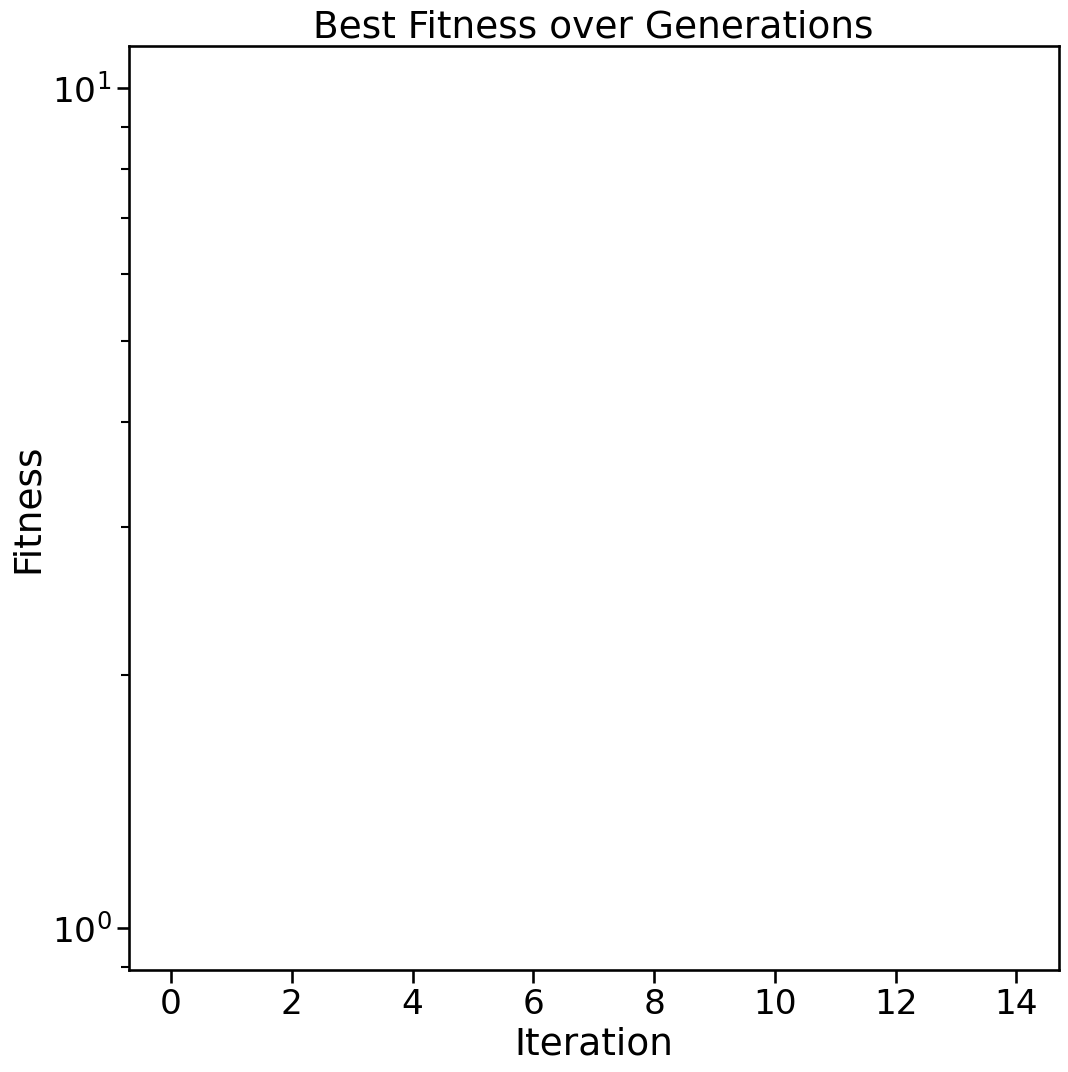

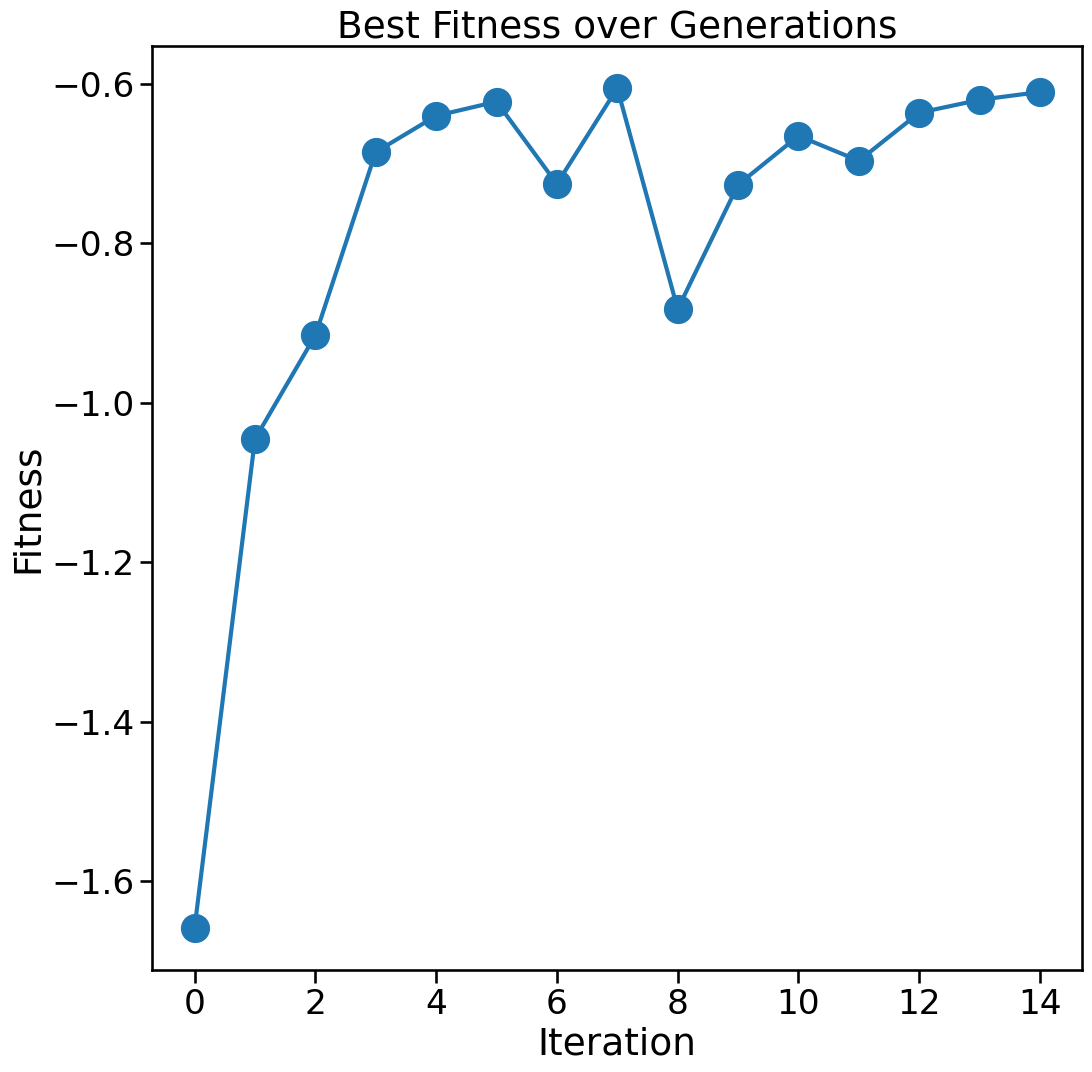

In [22]:
import pylab as plt
import seaborn as sns
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})


%matplotlib inline
plt.figure(figsize=(12,12))
plt.plot(fitnesses,'-o', lw=3, ms=20, label='from scratch')
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.title("Best Fitness over Generations")
plt.yscale("log")
plt.show()

%matplotlib inline
plt.figure(figsize=(12,12))
plt.plot(fitnesses,'-o', lw=3, ms=20, label='from scratch')
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.title("Best Fitness over Generations")
plt.yscale("linear")
plt.show()